In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
player_mapping = {
    "Jakeem Grant Sr.": "Jakeem Grant",
    "Gardner Minshew II": "Gardner Minshew",
    "Cedrick Wilson Jr.": "Cedrick Wilson",
    "Michael Pittman Jr.": "Michael Pittman",
    "Odell Beckham Jr.": "Odell Beckham",
    "AJ Dillon": "A.J. Dillon",
    "Marvin Jones Jr.": "Marvin Jones",
    "Steve Smith Sr.": "Steve Smith",
    "Allen Robinson II": "Allen Robinson",
    "Laviska Shenault Jr.": "Laviska Shenault",
    "Gabriel Davis": "Gabe Davis",
    "Scotty Miller": "Scott Miller",
    "Patrick Mahomes II": "Patrick Mahomes",
    "DJ Chark Jr.": "D.J. Chark",
    "DJ Moore": "D.J. Moore",
    "Melvin Gordon III": "Melvin Gordon",
}

week_mapping = {"Divisional": 20, "Super Bowl LVI": 22}


def apply_player_mapping(x):
    if x in player_mapping:
        return player_mapping[x]
    else:
        return x


def apply_week_mapping(x):
    if x in week_mapping:
        return week_mapping[x]
    else:
        return int(x)


In [3]:
df = pd.read_csv("data/current_allday_data.csv.gz")


/tmp/ipykernel_2560/2607107486.py:1: DtypeWarning: Columns (10,20,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/current_allday_data.csv.gz")


In [4]:
df['player_display_name'] = df.Player.apply(apply_player_mapping)
df['week'] = df.Week.apply(apply_week_mapping)

In [5]:
df = df.drop(columns = ["Sales_Count", "Resell_Number"])

In [6]:
# NOTE: for this analysis, counting sales by the marketplace_ID (all serial numbers) instead of a specific serial number
sales_counts = (
    df.groupby("marketplace_id")["tx_id"]
    .count()
    .reset_index()
    .sort_values(by="tx_id")
    .rename(columns={"tx_id": "Sales_Count"})
)
df = df.merge(sales_counts, on="marketplace_id")
df["Resell_Number"] = df.groupby("marketplace_id")["tx_id"].cumcount()

In [7]:
df.columns

Index(['Datetime', 'Date', 'tx_id', 'Price', 'Buyer', 'Seller', 'Player',
       'Team', 'Position', 'Season', 'Week', 'Play_Type', 'Moment_Date',
       'Moment_Tier', 'NFLALLDAY_ID', 'Serial_Number', 'Away_Team_Name',
       'Away_Team_Score', 'Distance', 'Down', 'NFL_ID', 'Quarter', 'Time',
       'Home_Team_Name', 'Home_Team_Score', 'Birthdate', 'Birthplace',
       'College', 'Draft_Number', 'Draft_Round', 'Draft_Team', 'Draft_Year',
       'Height', 'Rookie_Year', 'Draft_State', 'Weight', 'Player_ID',
       'Player_Number', 'image', 'Classification', 'Total_Circulation',
       'Moment_Description', 'NFT_ID', 'Series', 'Set_Name', 'unique_id',
       'marketplace_id', 'NFLALLDAY_ASSETS_URL', 'site', 'Rarity',
       'all_day_debut', 'rookie_year', 'rookie_mint', 'description_td',
       'game_td', 'pbp_td', 'scored_td_in_game', 'scored_td_in_moment',
       'won_game', 'tie_game', 'Game Outcome', 'player_display_name', 'week',
       'Sales_Count', 'Resell_Number'],
      dtype=

In [8]:
stats_df = pd.read_csv("data/weekly_data.csv")

In [9]:
stats_df = stats_df.dropna(subset='player_display_name')

In [10]:
season_stats_df = pd.read_csv("data/season_data.csv")

In [11]:
career_avg = (
    season_stats_df.groupby("player_id")[
        [
            "completions",
            "attempts",
            "passing_yards",
            "passing_tds",
            "interceptions",
            "sacks",
            "sack_fumbles_lost",
            "passing_epa",
            "carries",
            "rushing_yards",
            "rushing_tds",
            "rushing_fumbles_lost",
            "rushing_epa",
            "receptions",
            "targets",
            "receiving_yards",
            "receiving_tds",
            "receiving_fumbles_lost",
            "receiving_epa",
            "fantasy_points_ppr",
        ]
    ]
    .mean()
    .reset_index()
)


In [12]:
subset = df[
    (df.Position.isin(["WR", "TE", "QB", "RB"]))
    #  & (df.Date >= "2022-09-08")
][
    [
        "Player",
        "player_display_name",
        "Position",
        "Team",
        "Rarity",
        "Play_Type",
        "Season",
        "week",
        "scored_td_in_moment",
        "Game Outcome",
        "Series",
        "Set_Name",
        "site",
        "marketplace_id",
        "Sales_Count",
        "Resell_Number",
        "Price",
    ]
].rename(
    columns={"Season": "season"}
)


In [13]:
merged = subset.merge(stats_df, on=["player_display_name",'season', 'week'], suffixes=[None, "_moment"])

In [14]:
merged = merged.merge(season_stats_df, on=["player_id", "season"], suffixes=[None, "_season"])

In [15]:
for x in [        "completions_season",
        "attempts_season",
        "passing_yards_season",
        "passing_tds_season",
        "interceptions_season",
        "sacks_season",
        "sack_fumbles_lost_season",
        "passing_epa_season",
        "carries_season",
        "rushing_yards_season",
        "rushing_tds_season",
        "rushing_fumbles_lost_season",
        "rushing_epa_season",
        "receptions_season",
        "targets_season",
        "receiving_yards_season",
        "receiving_tds_season",
        "receiving_fumbles_lost_season",
        "receiving_epa_season",
        "fantasy_points_ppr_season"]:
    merged[x] = merged[x] / merged.games

In [16]:
merged = merged[
    [  # extra info
        "player_id",
        "site",
        "season",
        "week",
        # y
        "Price",
        # X
        "Position",
        "player_display_name",
        "Team",
        "Rarity",
        "Play_Type",
        "scored_td_in_moment",
        "Game Outcome",
        "Series",
        "Set_Name",
        "marketplace_id",
        "Sales_Count",
        "Resell_Number",
        "completions",
        "attempts",
        "passing_yards",
        "passing_tds",
        "interceptions",
        "sacks",
        "sack_fumbles_lost",
        "passing_epa",
        "carries",
        "rushing_yards",
        "rushing_tds",
        "rushing_fumbles_lost",
        "rushing_epa",
        "receptions",
        "targets",
        "receiving_yards",
        "receiving_tds",
        "receiving_fumbles_lost",
        "receiving_epa",
        "fantasy_points_ppr",
        "completions_season",
        "attempts_season",
        "passing_yards_season",
        "passing_tds_season",
        "interceptions_season",
        "sacks_season",
        "sack_fumbles_lost_season",
        "passing_epa_season",
        "carries_season",
        "rushing_yards_season",
        "rushing_tds_season",
        "rushing_fumbles_lost_season",
        "rushing_epa_season",
        "receptions_season",
        "targets_season",
        "receiving_yards_season",
        "receiving_tds_season",
        "receiving_fumbles_lost_season",
        "receiving_epa_season",
        "fantasy_points_ppr_season",
    ]
]


In [17]:
merged = merged.merge(career_avg, on=["player_id"], suffixes=[None, "_career"])

In [18]:
merged.tail().T[:60]

1220843  \
player_id                                                     00-0011024   
site                           https://nflallday.com/listing/moment/1134   
season                                                              2003   
week                                                                  16   
Price                                                                689   
Position                                                              QB   
player_display_name                                         Steve McNair   
Team                                                    Tennessee Titans   
Rarity                                                                 1   
Play_Type                                                    Player Melt   
scored_td_in_moment                                                False   
Game Outcome                                                         Win   
Series                                                        Historical   
Set_Name                                                          Legacy   
marketplace_id                                                      1134   
Sales_Count                                                           11   
Resell_Number                                                          6   
completions                                                           17   
attempts                                                              36   
passing_yards                                                      268.0   
passing_tds                                                            2   
interceptions                                                        1.0   
sacks                                                                0.0   
sack_fumbles_lost                                                      0   
passing_epa                                                    -3.594047   
carries                                                                3   
rushing_yards                                                        5.0   
rushing_tds                                                            0   
rushing_fumbles_lost                                                 0.0   
rushing_epa                                                    -1.658796   
receptions                                                             0   
targets                                                                0   
receiving_yards                                                      0.0   
receiving_tds                                                          0   
receiving_fumbles_lost                                               0.0   
receiving_epa                                                        NaN   
fantasy_points_ppr                                                 17.22   
completions_season                                             17.857143   
attempts_season                                                28.571429   
passing_yards_season                                          229.642857   
passing_tds_season                                              1.714286   
interceptions_season                                                 0.5   
sacks_season                                                    1.357143   
sack_fumbles_lost_season                                        0.285714   
passing_epa_season                                              7.524965   
carries_season                                                  2.714286   
rushing_yards_season                                            9.857143   
rushing_tds_season                                              0.285714   
rushing_fumbles_lost_season                                     0.142857   
rushing_epa_season                                             -0.111466   
receptions_season                                               0.071429   
targets_season                                                  0.071429   
receiving_yards_season               

In [19]:
del df
del stats_df
del subset
del season_stats_df

## Initial run (for feature importance)

In [20]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from scipy.stats import skew
from collections import OrderedDict


In [21]:
categorical_features = [
    # "Position",
    # "Team",
    # "player_display_name",
    "Play_Type",
    "Series",
    "Set_Name",
    "Game Outcome",
    # "Rarity"
]
y_cols = ["Price"]
info_cols = [
    "player_display_name",
    "player_id",
    "site",
    "Team",
     "Position",
    "season",
    "week",
    "marketplace_id",
    "scored_td_in_moment"
    # "Game Outcome",
    # "Sales_Count",
    # "Resell_Number",
]
train_dataset = merged.copy()

every_column_except_y = [col for col in train_dataset.columns if col not in y_cols + info_cols]
every_column_non_categorical= [col for col in train_dataset.columns if col not in categorical_features +  info_cols ]
numeric_feats = train_dataset[every_column_non_categorical].dtypes[train_dataset.dtypes != "object"].index
numeric_no_price = numeric_feats.drop('Price')

In [22]:
skewed_feats = train_dataset[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index


In [23]:
numeric_no_price

Index(['Rarity', 'Sales_Count', 'Resell_Number', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks',
       'sack_fumbles_lost', 'passing_epa', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles_lost', 'rushing_epa', 'receptions',
       'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost',
       'receiving_epa', 'fantasy_points_ppr', 'completions_season',
       'attempts_season', 'passing_yards_season', 'passing_tds_season',
       'interceptions_season', 'sacks_season', 'sack_fumbles_lost_season',
       'passing_epa_season', 'carries_season', 'rushing_yards_season',
       'rushing_tds_season', 'rushing_fumbles_lost_season',
       'rushing_epa_season', 'receptions_season', 'targets_season',
       'receiving_yards_season', 'receiving_tds_season',
       'receiving_fumbles_lost_season', 'receiving_epa_season',
       'fantasy_points_ppr_season', 'completions_career', 'attempts_career',
       'passing_yards

In [24]:
train_dataset[skewed_feats] = np.log1p(train_dataset[skewed_feats])

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [25]:
train_dataset = train_dataset.replace(-1*np.inf, 0) # get rid of negative infinity values from fixing skew

In [26]:
train_dataset = pd.get_dummies(train_dataset,columns =categorical_features)

In [27]:
train_dataset

player_id                                       site  season  week  \
0        00-0036326   https://nflallday.com/listing/moment/371    2021    13   
1        00-0036326   https://nflallday.com/listing/moment/371    2021    13   
2        00-0036326   https://nflallday.com/listing/moment/371    2021    13   
3        00-0036326   https://nflallday.com/listing/moment/371    2021    13   
4        00-0036326   https://nflallday.com/listing/moment/371    2021    13   
...             ...                                        ...     ...   ...   
1220843  00-0011024  https://nflallday.com/listing/moment/1134    2003    16   
1220844  00-0011024  https://nflallday.com/listing/moment/1134    2003    16   
1220845  00-0011024  https://nflallday.com/listing/moment/1134    2003    16   
1220846  00-0011024  https://nflallday.com/listing/moment/1134    2003    16   
1220847  00-0011024  https://nflallday.com/listing/moment/1134    2003    16   

            Price Position player_display_name                 Team    Rarity  \
0        1.791759       WR      Chase Claypool  Pittsburgh Steelers  0.000000   
1        1.791759       WR      Chase Claypool  Pittsburgh Steelers  0.000000   
2        3.931826       WR      Chase Claypool  Pittsburgh Steelers  0.000000   
3        4.394449       WR      Chase Claypool  Pittsburgh Steelers  0.000000   
4        2.944439       WR      Chase Claypool  Pittsburgh Steelers  0.000000   
...           ...      ...                 ...                  ...       ...   
1220843  6.536692       QB        Steve McNair     Tennessee Titans  0.693147   
1220844  4.663439       QB        Steve McNair     Tennessee Titans  0.693147   
1220845  4.753590       QB        Steve McNair     Tennessee Titans  0.693147   
1220846  4.682131       QB        Steve McNair     Tennessee Titans  0.693147   
1220847  4.682131       QB        Steve McNair     Tennessee Titans  0.693147   

         scored_td_in_moment  ...  Set_Name_Rookie Revelation  \
0                      False  ...                           0   
1                      False  ...                           0   
2                      False  ...                           0   
3                      False  ...                           0   
4                      False  ...                           0   
...                      ...  ...                         ...   
1220843                False  ...                           0   
1220844                False  ...                           0   
1220845                False  ...                           0   
1220846                False  ...                           0   
1220847                False  ...                           0   

         Set_Name_Setting the Bar  Set_Name_Showtime  Set_Name_Super Bowl LVI  \
0                               0                  0                        0   
1                               0                  0                        0   
2                               0                  0                        0   
3                               0                  0                        0   
4                               0                  0                        0   
...                           ...                ...                      ...   
1220843                         0                  0                        0   
1220844                         0                  0                        0   
1220845                         0                  0                        0   
1220846                         0                  0                        0   
1220847                         0                  0                        0   

         Set_Name_Super Wild Card Weekend  Set_Name_Unforgettable  \
0                                       0                       0   
1                                       0                       0   
2                                       0                       0   
3                                       0     

In [28]:
# model = xgboost.XGBRegressor(
#     # colsample_bytree=0.4,
#     # gamma=0,
#     # learning_rate=0.07,
#     # max_depth=3,
#     # min_child_weight=1.5,
#     # n_estimators=100,
#     # reg_alpha=0.75,
#     # reg_lambda=0.45,
#     # subsample=0.6,
#     # seed=42,
# )

model = xgboost.XGBRegressor(
        learning_rate=0.01,
        n_estimators=1000,
        importance_type='gain',
)



In [29]:
feature_cols = [col for col in train_dataset.columns if col not in y_cols+info_cols]

In [30]:
X = train_dataset[feature_cols]
y = train_dataset[y_cols]
scaler = RobustScaler()
X[numeric_no_price] = scaler.fit_transform(X[numeric_no_price])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/tmp/ipykernel_2560/863186441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_no_price] = scaler.fit_transform(X[numeric_no_price])


In [31]:
X.columns

Index(['Rarity', 'Sales_Count', 'Resell_Number', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks',
       'sack_fumbles_lost',
       ...
       'Set_Name_Rookie Revelation', 'Set_Name_Setting the Bar',
       'Set_Name_Showtime', 'Set_Name_Super Bowl LVI',
       'Set_Name_Super Wild Card Weekend', 'Set_Name_Unforgettable',
       'Set_Name_What a Drive', 'Game Outcome_Loss', 'Game Outcome_Tie',
       'Game Outcome_Win'],
      dtype='object', length=103)

In [32]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:2.66111
[1]	validation_0-rmse:2.63560
[2]	validation_0-rmse:2.61035
[3]	validation_0-rmse:2.58537
[4]	validation_0-rmse:2.56064
[5]	validation_0-rmse:2.53618
[6]	validation_0-rmse:2.51195
[7]	validation_0-rmse:2.48796
[8]	validation_0-rmse:2.46425
[9]	validation_0-rmse:2.44076
[10]	validation_0-rmse:2.41755
[11]	validation_0-rmse:2.39456
[12]	validation_0-rmse:2.37183
[13]	validation_0-rmse:2.34931
[14]	validation_0-rmse:2.32704
[15]	validation_0-rmse:2.30502
[16]	validation_0-rmse:2.28322
[17]	validation_0-rmse:2.26165
[18]	validation_0-rmse:2.24031
[19]	validation_0-rmse:2.21920
[20]	validation_0-rmse:2.19828
[21]	validation_0-rmse:2.17761
[22]	validation_0-rmse:2.15716
[23]	validation_0-rmse:2.13693
[24]	validation_0-rmse:2.11690
[25]	validation_0-rmse:2.09708
[26]	validation_0-rmse:2.07747
[27]	validation_0-rmse:2.05806
[28]	validation_0-rmse:2.03887
[29]	validation_0-rmse:2.01985
[30]	validation_0-rmse:2.00105
[31]	validation_0-rmse:1.98245
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [33]:
X.columns

Index(['Rarity', 'Sales_Count', 'Resell_Number', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks',
       'sack_fumbles_lost',
       ...
       'Set_Name_Rookie Revelation', 'Set_Name_Setting the Bar',
       'Set_Name_Showtime', 'Set_Name_Super Bowl LVI',
       'Set_Name_Super Wild Card Weekend', 'Set_Name_Unforgettable',
       'Set_Name_What a Drive', 'Game Outcome_Loss', 'Game Outcome_Tie',
       'Game Outcome_Win'],
      dtype='object', length=103)

In [34]:
hot_features = pd.DataFrame(
    model.feature_importances_.reshape(1, len(model.feature_importances_)),
    columns=model.feature_names_in_,
)
sorted_importance = hot_features.T.sort_values(by=0, ascending=False).reset_index()

In [35]:
sorted_importance[:60]
sorted_importance[-60:]

index         0
43                         passing_epa  0.004434
44                  passing_epa_season  0.004421
45                receiving_tds_season  0.004021
46                  rushing_tds_season  0.004018
47                      targets_season  0.003932
48                               sacks  0.003802
49                  rushing_tds_career  0.003796
50                  passing_tds_season  0.003793
51                receiving_epa_career  0.003573
52       receiving_fumbles_lost_season  0.003276
53   Set_Name_Conference Championships  0.003177
54         rushing_fumbles_lost_career  0.003134
55                         passing_tds  0.003050
56               Set_Name_Launch Codes  0.003018
57                             targets  0.002994
58                       passing_yards  0.002984
59               Play_Type_Player Melt  0.002927
60                          receptions  0.002527
61                passing_yards_career  0.002509
62    Set_Name_Super Wild Card Weekend  0.002254
63                  Set_Name_Rivalries  0.002032
64                  Set_Name_Locked In  0.001959
65              receiving_yards_season  0.001942
66                    Game Outcome_Win  0.001805
67                     attempts_career  0.001780
68                         rushing_epa  0.001755
69                rushing_yards_season  0.001735
70             Set_Name_Super Bowl LVI  0.001668
71                         completions  0.001508
72                   Set_Name_Showtime  0.001405
73                       receiving_tds  0.001207
74                  completions_career  0.001199
75              Play_Type_2-Pt Attempt  0.001154
76              receiving_fumbles_lost  0.001042
77           Set_Name_Divisional Round  0.000942
78   Set_Name_Heroes and Heartbreakers  0.000756
79                       Resell_Number  0.000737
80                      Play_Type_Rush  0.000683
81                 Play_Type_Reception  0.000593
82              Set_Name_Game Changers  0.000503
83                     Series_Series 2  0.000490
84                   sack_fumbles_lost  0.000440
85                     attempts_season  0.000417
86                    Game Outcome_Tie  0.000414
87               Set_Name_Afterburners  0.000261
88          Set_Name_Rookie Revelation  0.000233
89                      Play_Type_Pass  0.000172
90              Set_Name_Unforgettable  0.000082
91          Set_Name_Against the Clock  0.000070
92                     Set_Name_Iconic  0.000059
93               Set_Name_What a Drive  0.000000
94               Play_Type_Punt Return  0.000000
95            Set_Name_Setting the Bar  0.000000
96                    Set_Name_Marquee  0.000000
97                     Set_Name_Legacy  0.000000
98                 Set_Name_Hoodwinked  0.000000
99                   Set_Name_Highwire  0.000000
100                Set_Name_Draw it Up  0.000000
101              Play_Type_Kick Return  0.000000
102         Set_Name_Inside the Pylons  0.000000

In [36]:
sorted_importance[sorted_importance['index'].str.startswith('player_display_name')].iloc[:50].reset_index()

Empty DataFrame
Columns: [level_0, index, 0]
Index: []

In [37]:
sorted_importance[sorted_importance['index'].str.startswith('Team_')].iloc[:50].reset_index()

Empty DataFrame
Columns: [level_0, index, 0]
Index: []

In [38]:
sorted_importance[sorted_importance['index'].str.startswith('Position_')].iloc[:50].reset_index()

Empty DataFrame
Columns: [level_0, index, 0]
Index: []

In [39]:
sorted_importance[sorted_importance['index'].str.startswith('Play_Type_')].iloc[:50].reset_index()

level_0                   index         0
0       59   Play_Type_Player Melt  0.002927
1       75  Play_Type_2-Pt Attempt  0.001154
2       80          Play_Type_Rush  0.000683
3       81     Play_Type_Reception  0.000593
4       89          Play_Type_Pass  0.000172
5       94   Play_Type_Punt Return  0.000000
6      101   Play_Type_Kick Return  0.000000

In [40]:
sorted_importance[sorted_importance['index'].str.startswith('Series_')].iloc[:50].reset_index()

level_0              index         0
0       27    Series_Series 1  0.006734
1       33  Series_Historical  0.006046
2       83    Series_Series 2  0.000490

In [41]:
sorted_importance[sorted_importance['index'].str.startswith('Set_Name')].iloc[:50].reset_index()

level_0                              index         0
0         4              Set_Name_Opening Acts  0.044810
1         9           Set_Name_Move the Chains  0.019508
2        14                  Set_Name_Gridiron  0.017335
3        17                      Set_Name_Base  0.013007
4        53  Set_Name_Conference Championships  0.003177
5        56              Set_Name_Launch Codes  0.003018
6        62   Set_Name_Super Wild Card Weekend  0.002254
7        63                 Set_Name_Rivalries  0.002032
8        64                 Set_Name_Locked In  0.001959
9        70            Set_Name_Super Bowl LVI  0.001668
10       72                  Set_Name_Showtime  0.001405
11       77          Set_Name_Divisional Round  0.000942
12       78  Set_Name_Heroes and Heartbreakers  0.000756
13       82             Set_Name_Game Changers  0.000503
14       87              Set_Name_Afterburners  0.000261
15       88         Set_Name_Rookie Revelation  0.000233
16       90             Set_Name_Unforgettable  0.000082
17       91         Set_Name_Against the Clock  0.000070
18       92                    Set_Name_Iconic  0.000059
19       93              Set_Name_What a Drive  0.000000
20       95           Set_Name_Setting the Bar  0.000000
21       96                   Set_Name_Marquee  0.000000
22       97                    Set_Name_Legacy  0.000000
23       98                Set_Name_Hoodwinked  0.000000
24       99                  Set_Name_Highwire  0.000000
25      100                Set_Name_Draw it Up  0.000000
26      102         Set_Name_Inside the Pylons  0.000000

In [42]:
sorted_importance[sorted_importance['index'].str.startswith('Game Outcome')].iloc[:50].reset_index()

level_0              index         0
0       18  Game Outcome_Loss  0.011319
1       66   Game Outcome_Win  0.001805
2       86   Game Outcome_Tie  0.000414

In [43]:
sorted_importance.iloc[:60]

index         0
0                              Rarity  0.204855
1                  passing_tds_career  0.077184
2                passing_yards_season  0.076570
3                  passing_epa_career  0.071396
4               Set_Name_Opening Acts  0.044810
5           fantasy_points_ppr_career  0.032136
6                        sacks_season  0.027338
7                         Sales_Count  0.022338
8              receiving_yards_career  0.022159
9            Set_Name_Move the Chains  0.019508
10                 completions_season  0.018794
11                           attempts  0.018698
12        rushing_fumbles_lost_season  0.018696
13          fantasy_points_ppr_season  0.018482
14                  Set_Name_Gridiron  0.017335
15           sack_fumbles_lost_season  0.016631
16                     carries_season  0.013077
17                      Set_Name_Base  0.013007
18                  Game Outcome_Loss  0.011319
19           sack_fumbles_lost_career  0.010808
20                     targets_career  0.010318
21               receiving_tds_career  0.008743
22                 rushing_epa_career  0.008352
23                        rushing_tds  0.008054
24               rushing_fumbles_lost  0.007696
25               rushing_yards_career  0.007664
26                 rushing_epa_season  0.006852
27                    Series_Series 1  0.006734
28                      receiving_epa  0.006721
29                    receiving_yards  0.006470
30                      interceptions  0.006452
31      receiving_fumbles_lost_career  0.006325
32                  receptions_season  0.006313
33                  Series_Historical  0.006046
34                     carries_career  0.006021
35                      rushing_yards  0.005779
36               interceptions_career  0.005132
37                 fantasy_points_ppr  0.005046
38               interceptions_season  0.005028
39               receiving_epa_season  0.004803
40                            carries  0.004601
41                  receptions_career  0.004572
42                       sacks_career  0.004452
43                        passing_epa  0.004434
44                 passing_epa_season  0.004421
45               receiving_tds_season  0.004021
46                 rushing_tds_season  0.004018
47                     targets_season  0.003932
48                              sacks  0.003802
49                 rushing_tds_career  0.003796
50                 passing_tds_season  0.003793
51               receiving_epa_career  0.003573
52      receiving_fumbles_lost_season  0.003276
53  Set_Name_Conference Championships  0.003177
54        rushing_fumbles_lost_career  0.003134
55                        passing_tds  0.003050
56              Set_Name_Launch Codes  0.003018
57                            targets  0.002994
58                      passing_yards  0.002984
59              Play_Type_Player Melt  0.002927

In [44]:
len(sorted_importance)

103

In [45]:
sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True)

[('Resell_Number', 25740.0),
 ('Sales_Count', 6710.0),
 ('receiving_epa', 1422.0),
 ('Rarity', 1313.0),
 ('fantasy_points_ppr', 1268.0),
 ('fantasy_points_ppr_season', 1256.0),
 ('rushing_epa', 1121.0),
 ('rushing_epa_career', 962.0),
 ('fantasy_points_ppr_career', 873.0),
 ('receiving_epa_season', 747.0),
 ('rushing_epa_season', 744.0),
 ('receptions', 704.0),
 ('receiving_yards', 637.0),
 ('rushing_yards_career', 633.0),
 ('carries', 614.0),
 ('rushing_yards', 613.0),
 ('passing_epa_career', 569.0),
 ('receiving_epa_career', 522.0),
 ('attempts', 453.0),
 ('carries_season', 415.0),
 ('targets_season', 408.0),
 ('receiving_tds_career', 405.0),
 ('Series_Series 1', 404.0),
 ('completions', 399.0),
 ('receptions_season', 382.0),
 ('targets_career', 349.0),
 ('Set_Name_Move the Chains', 348.0),
 ('receiving_yards_season', 340.0),
 ('passing_epa', 332.0),
 ('targets', 329.0),
 ('receiving_tds_season', 327.0),
 ('completions_season', 309.0),
 ('Set_Name_Base', 309.0),
 ('receiving_yards_ca

## only important features

In [46]:
# important_players = (
#     sorted_importance[sorted_importance["index"].str.startswith("player_display_name_")]
#     .reset_index(drop=True)
#     .iloc[:16]["index"]
#     .str.split("player_display_name_")
#     .str[1]
#     .values
# )
# merged["Player_importance"] = merged.player_display_name.apply(
#     lambda x: x if x in important_players else "Other"
# )

# important_postions = (
#     sorted_importance[sorted_importance["index"].str.startswith("Position_")]
#     .reset_index(drop=True)
#     .iloc[:2]["index"]
#     .str.split("Position_")
#     .str[1]
#     .values
# )
# merged["Position_importance"] = merged.Position.apply(
#     lambda x: x if x in important_postions else "Other"
# )

# important_teams = (
#     sorted_importance[sorted_importance["index"].str.startswith("Team_")]
#     .reset_index(drop=True)
#     .iloc[:13]["index"]
#     .str.split("Team_")
#     .str[1]
#     .values
# )
# merged["Team_importance"] = merged.Team.apply(
#     lambda x: x if x in important_teams else "Other"
# )

important_play_types = (
    sorted_importance[sorted_importance["index"].str.startswith("Play_Type_")]
    .reset_index(drop=True)
    .iloc[:2]["index"]
    .str.split("Play_Type_")
    .str[1]
    .values
)
merged["Play_Type_importance"] = merged.Play_Type.apply(
    lambda x: x if x in important_play_types else "Other"
)

important_set_names = (
    sorted_importance[sorted_importance["index"].str.startswith("Set_Name_")]
    .reset_index(drop=True)
    .iloc[:4]["index"]
    .str.split("Set_Name_")
    .str[1]
    .values
)
merged["Set_Name_importance"] = merged.Set_Name.apply(
    lambda x: x if x in important_set_names else "Other"
)

In [47]:
categorical_features = [
    # "Position",
    # "Team",
    # "player_display_name",
    "Series",
    "Game Outcome",
    # "Play_Type_importance",
    "Set_Name_importance",
    # "Rarity"
]
y_cols = ["Price"]
info_cols = [
    "player_display_name",
    "player_id",
    "site",
    "Team",
     "Position",
    "season",
    "week",
    "marketplace_id",
    "scored_td_in_moment",
    "Play_Type",
    "Set_Name",
    "Play_Type_importance",
    # "Game Outcome",
    # "Sales_Count",
    # "Resell_Number",
]
train_dataset = merged.copy()

every_column_except_y = [col for col in train_dataset.columns if col not in y_cols + info_cols]
every_column_non_categorical= [col for col in train_dataset.columns if col not in categorical_features +  info_cols ]
numeric_feats = train_dataset[every_column_non_categorical].dtypes[train_dataset.dtypes != "object"].index
numeric_no_price = numeric_feats.drop('Price')


skewed_feats = train_dataset[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
train_dataset[skewed_feats] = np.log1p(train_dataset[skewed_feats])
train_dataset = train_dataset.replace(-1*np.inf, 0) # get rid of negative infinity values from fixing skew

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [48]:
train_dataset = pd.get_dummies(train_dataset,columns=categorical_features)

In [49]:
feature_cols = [col for col in train_dataset.columns if col not in y_cols+info_cols and col not in ['Game Outcome_Tie']]


In [50]:
X = train_dataset[feature_cols]
y = train_dataset[y_cols]

scaler = RobustScaler()
numeric_no_price = numeric_feats.drop('Price')
X[numeric_no_price] = scaler.fit_transform(X[numeric_no_price])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/tmp/ipykernel_2560/1425197294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_no_price] = scaler.fit_transform(X[numeric_no_price])


In [51]:
xgb_model = xgboost.XGBRegressor(
    learning_rate=0.01,
    n_estimators=1000
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:2.66111
[1]	validation_0-rmse:2.63560
[2]	validation_0-rmse:2.61035
[3]	validation_0-rmse:2.58537
[4]	validation_0-rmse:2.56064
[5]	validation_0-rmse:2.53618
[6]	validation_0-rmse:2.51195
[7]	validation_0-rmse:2.48796
[8]	validation_0-rmse:2.46425
[9]	validation_0-rmse:2.44077
[10]	validation_0-rmse:2.41755
[11]	validation_0-rmse:2.39456
[12]	validation_0-rmse:2.37183
[13]	validation_0-rmse:2.34931
[14]	validation_0-rmse:2.32704
[15]	validation_0-rmse:2.30502
[16]	validation_0-rmse:2.28322
[17]	validation_0-rmse:2.26165
[18]	validation_0-rmse:2.24031
[19]	validation_0-rmse:2.21920
[20]	validation_0-rmse:2.19828
[21]	validation_0-rmse:2.17761
[22]	validation_0-rmse:2.15716
[23]	validation_0-rmse:2.13693
[24]	validation_0-rmse:2.11690
[25]	validation_0-rmse:2.09708
[26]	validation_0-rmse:2.07747
[27]	validation_0-rmse:2.05806
[28]	validation_0-rmse:2.03886
[29]	validation_0-rmse:2.01985
[30]	validation_0-rmse:2.00105
[31]	validation_0-rmse:1.98245
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [52]:

hot_features = pd.DataFrame(
    xgb_model.feature_importances_.reshape(1, len(xgb_model.feature_importances_)),
    columns=xgb_model.feature_names_in_,
)
sorted_importance2 = hot_features.T.sort_values(by=0, ascending=False).reset_index()

In [53]:
sorted_importance2[sorted_importance2['index'].str.startswith('Player_')].iloc[:50].reset_index()

Empty DataFrame
Columns: [level_0, index, 0]
Index: []

In [54]:
sorted_importance2[sorted_importance2['index'].str.startswith('Team_')].iloc[:50].reset_index()

Empty DataFrame
Columns: [level_0, index, 0]
Index: []

In [55]:
sorted_importance2[sorted_importance2['index'].str.startswith('Position_')].iloc[:50].reset_index()

Empty DataFrame
Columns: [level_0, index, 0]
Index: []

In [56]:
sorted_importance2[sorted_importance2['index'].str.startswith('Play_Type_')].iloc[:50].reset_index()

Empty DataFrame
Columns: [level_0, index, 0]
Index: []

In [57]:
sorted_importance2[sorted_importance2['index'].str.startswith('Series_')].iloc[:50].reset_index()

level_0              index         0
0       23    Series_Series 1  0.007978
1       27  Series_Historical  0.006979
2       68    Series_Series 2  0.001019

In [58]:
sorted_importance2[sorted_importance2['index'].str.startswith('Set_Name')].iloc[:50].reset_index()

level_0                                index         0
0        3     Set_Name_importance_Opening Acts  0.055097
1        7  Set_Name_importance_Move the Chains  0.027371
2       13             Set_Name_importance_Base  0.018580
3       16         Set_Name_importance_Gridiron  0.015867
4       34            Set_Name_importance_Other  0.005707

In [59]:
sorted_importance2[sorted_importance2['index'].str.startswith('Game Outcome')].iloc[:50].reset_index()

level_0              index         0
0       26  Game Outcome_Loss  0.007073
1       67   Game Outcome_Win  0.001043

## Final model selection run

NO LONGER NEEDED

In [145]:
important_players = (
    sorted_importance2[sorted_importance2["index"].str.startswith("Player_")]
    .reset_index(drop=True)
    .iloc[:10]["index"]
    .str.split("Player_importance_")
    .str[1]
    .values
)
merged["Player_importance"] = merged.player_display_name.apply(
    lambda x: x if x in important_players else "Other"
)

important_postions = (
    sorted_importance2[sorted_importance2["index"].str.startswith("Position_")]
    .reset_index(drop=True)
    .iloc[:2]["index"]
    .str.split("Position_importance_")
    .str[1]
    .values
)
merged["Position_importance"] = merged.Position.apply(
    lambda x: x if x in important_postions else "Other"
)


important_teams = (
    sorted_importance2[sorted_importance2["index"].str.startswith("Team_")]
    .reset_index(drop=True)
    .iloc[:9]["index"]
    .str.split("Team_importance_")
    .str[1]
    .values
)
merged["Team_importance"] = merged.Team.apply(
    lambda x: x if x in important_teams else "Other"
)

important_play_types = (
    sorted_importance2[sorted_importance2["index"].str.startswith("Play_Type_")]
    .reset_index(drop=True)
    .iloc[:1]["index"]
    .str.split("Play_Type_importance_")
    .str[1]
    .values
)
merged["Play_Type_importance"] = merged.Play_Type.apply(
    lambda x: x if x in important_play_types else "Other"
)

important_set_names = (
    sorted_importance2[sorted_importance2["index"].str.startswith("Set_Name_")]
    .reset_index(drop=True)
    .iloc[:7]["index"]
    .str.split("Set_Name_importance_")
    .str[1]
    .values
)
merged["Set_Name_importance"] = merged.Set_Name.apply(
    lambda x: x if x in important_set_names else "Other"
)

In [146]:
categorical_features = [
    "Team_importance",
    "Player_importance",
    "Series",
    "Set_Name_importance",
    "Position_importance", 
    "Game Outcome"
]
y_cols = ["Price"]
info_cols = [
    "player_id",
    "site",
    "season",
    "week",
    "marketplace_id",
    # Now using importance versions:
    "player_display_name",
    "Team",
    "Player",
    "Play_Type",
    "Set_Name",
    "Position",
    # Not coming out as important
    # "Position_importance", 
    "Play_Type_importance",
]
train_dataset = merged.copy()


every_column_except_y = [col for col in train_dataset.columns if col not in y_cols + info_cols]
every_column_non_categorical= [col for col in train_dataset.columns if col not in categorical_features +  info_cols ]
numeric_feats = train_dataset[every_column_non_categorical].dtypes[train_dataset.dtypes != "object"].index

skewed_feats = train_dataset[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
train_dataset[skewed_feats] = np.log1p(train_dataset[skewed_feats])
train_dataset = train_dataset.replace(-1*np.inf, 0) # get rid of negative infinity values from fixing skew

train_dataset = pd.get_dummies(train_dataset,columns=categorical_features)
feature_cols = [col for col in train_dataset.columns if col not in y_cols+info_cols and col not in ['Game Outcome_Tie', 'rushing_fumbles_lost']]

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [147]:
len(feature_cols)

98

In [148]:
feature_cols

['Rarity',
 'scored_td_in_moment',
 'Sales_Count',
 'Resell_Number',
 'completions',
 'attempts',
 'passing_yards',
 'passing_tds',
 'interceptions',
 'sacks',
 'sack_fumbles_lost',
 'passing_epa',
 'carries',
 'rushing_yards',
 'rushing_tds',
 'rushing_epa',
 'receptions',
 'targets',
 'receiving_yards',
 'receiving_tds',
 'receiving_fumbles_lost',
 'receiving_epa',
 'fantasy_points_ppr',
 'completions_season',
 'attempts_season',
 'passing_yards_season',
 'passing_tds_season',
 'interceptions_season',
 'sacks_season',
 'sack_fumbles_lost_season',
 'passing_epa_season',
 'carries_season',
 'rushing_yards_season',
 'rushing_tds_season',
 'rushing_fumbles_lost_season',
 'rushing_epa_season',
 'receptions_season',
 'targets_season',
 'receiving_yards_season',
 'receiving_tds_season',
 'receiving_fumbles_lost_season',
 'receiving_epa_season',
 'fantasy_points_ppr_season',
 'completions_career',
 'attempts_career',
 'passing_yards_career',
 'passing_tds_career',
 'interceptions_career',
 '

In [192]:
X = train_dataset[feature_cols]
y = train_dataset[y_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_model = xgboost.XGBRegressor(
    learning_rate=0.01,
    n_estimators=1000
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

[0]	validation_0-rmse:2.66111	validation_1-rmse:2.66538
[1]	validation_0-rmse:2.63560	validation_1-rmse:2.63985
[2]	validation_0-rmse:2.61036	validation_1-rmse:2.61458
[3]	validation_0-rmse:2.58537	validation_1-rmse:2.58958
[4]	validation_0-rmse:2.56065	validation_1-rmse:2.56484
[5]	validation_0-rmse:2.53618	validation_1-rmse:2.54035
[6]	validation_0-rmse:2.51196	validation_1-rmse:2.51611
[7]	validation_0-rmse:2.48797	validation_1-rmse:2.49211
[8]	validation_0-rmse:2.46426	validation_1-rmse:2.46838
[9]	validation_0-rmse:2.44077	validation_1-rmse:2.44488
[10]	validation_0-rmse:2.41757	validation_1-rmse:2.42165
[11]	validation_0-rmse:2.39458	validation_1-rmse:2.39864
[12]	validation_0-rmse:2.37182	validation_1-rmse:2.37587
[13]	validation_0-rmse:2.34932	validation_1-rmse:2.35335
[14]	validation_0-rmse:2.32706	validation_1-rmse:2.33107
[15]	validation_0-rmse:2.30501	validation_1-rmse:2.30901
[16]	validation_0-rmse:2.28321	validation_1-rmse:2.28719
[17]	validation_0-rmse:2.26164	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [193]:
hot_features = pd.DataFrame(
    xgb_model.feature_importances_.reshape(1, len(xgb_model.feature_importances_)),
    columns=xgb_model.feature_names_in_,
)
sorted_importance3 = hot_features.T.sort_values(by=0, ascending=False).reset_index()

In [194]:
sorted_importance3[-30:]

index         0
68                               targets  0.002739
69       Player_importance_George Kittle  0.002556
70             Set_Name_importance_Other  0.002537
71    Player_importance_Devin Singletary  0.002528
72         receiving_fumbles_lost_season  0.002474
73                            receptions  0.002445
74  Team_importance_Jacksonville Jaguars  0.002321
75                    rushing_tds_career  0.002315
76         Player_importance_Zach Wilson  0.002304
77     Team_importance_Arizona Cardinals  0.002240
78                       attempts_career  0.002095
79                           rushing_epa  0.002020
80                Position_importance_TE  0.001942
81                      Game Outcome_Win  0.001776
82                receiving_yards_season  0.001724
83                    completions_career  0.001677
84           rushing_fumbles_lost_career  0.001591
85                  rushing_yards_season  0.001421
86                   scored_td_in_moment  0.001258
87        Player_importance_Javon Walker  0.001248
88                       attempts_season  0.001171
89                  passing_yards_career  0.001030
90    Team_importance_New Orleans Saints  0.000902
91                           completions  0.000865
92                receiving_fumbles_lost  0.000652
93                         Resell_Number  0.000589
94                       Series_Series 2  0.000550
95                     sack_fumbles_lost  0.000316
96                 Team_importance_Other  0.000133
97             Position_importance_Other  0.000000

In [195]:
len(sorted(xgb_model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

97

## ML analysis

In [91]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error
from mlxtend.regressor import StackingCVRegressor
from joblib import dump, load

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
def cv_rmse(model, X=X, y=y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [61]:
dump(xgb_model, 'xgbmodel.joblib')

['xgbmodel.joblib']

/tmp/ipykernel_2318/1919360478.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged.corr(), cmap="RdBu")


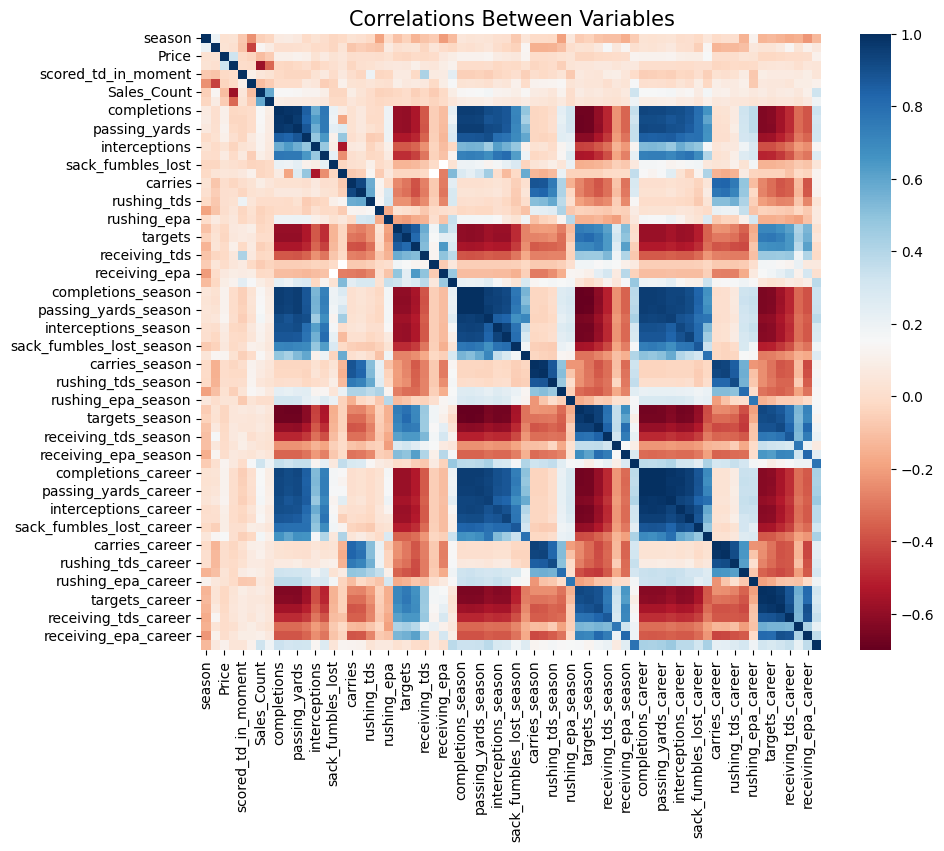

In [62]:
plt.figure(figsize=(10,8))
sns.heatmap(merged.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

In [63]:
sorted_importance2.head(10).sum()

index    Raritypassing_epa_careerpassing_yards_seasonSe...
0                                                 0.606321
dtype: object

In [64]:
unscaled = X.copy()
unscaled[numeric_no_price] = scaler.inverse_transform(unscaled[numeric_no_price])

unscaled = pd.concat([unscaled, y], axis=1)
unscaled[skewed_feats] = np.expm1(unscaled[skewed_feats])
# 
unscaled['Price'] = np.log(unscaled['Price'])
unscaled = unscaled.rename(columns={"Price":"Price (log)"})

In [65]:
sampled_data = unscaled.sample(1500)

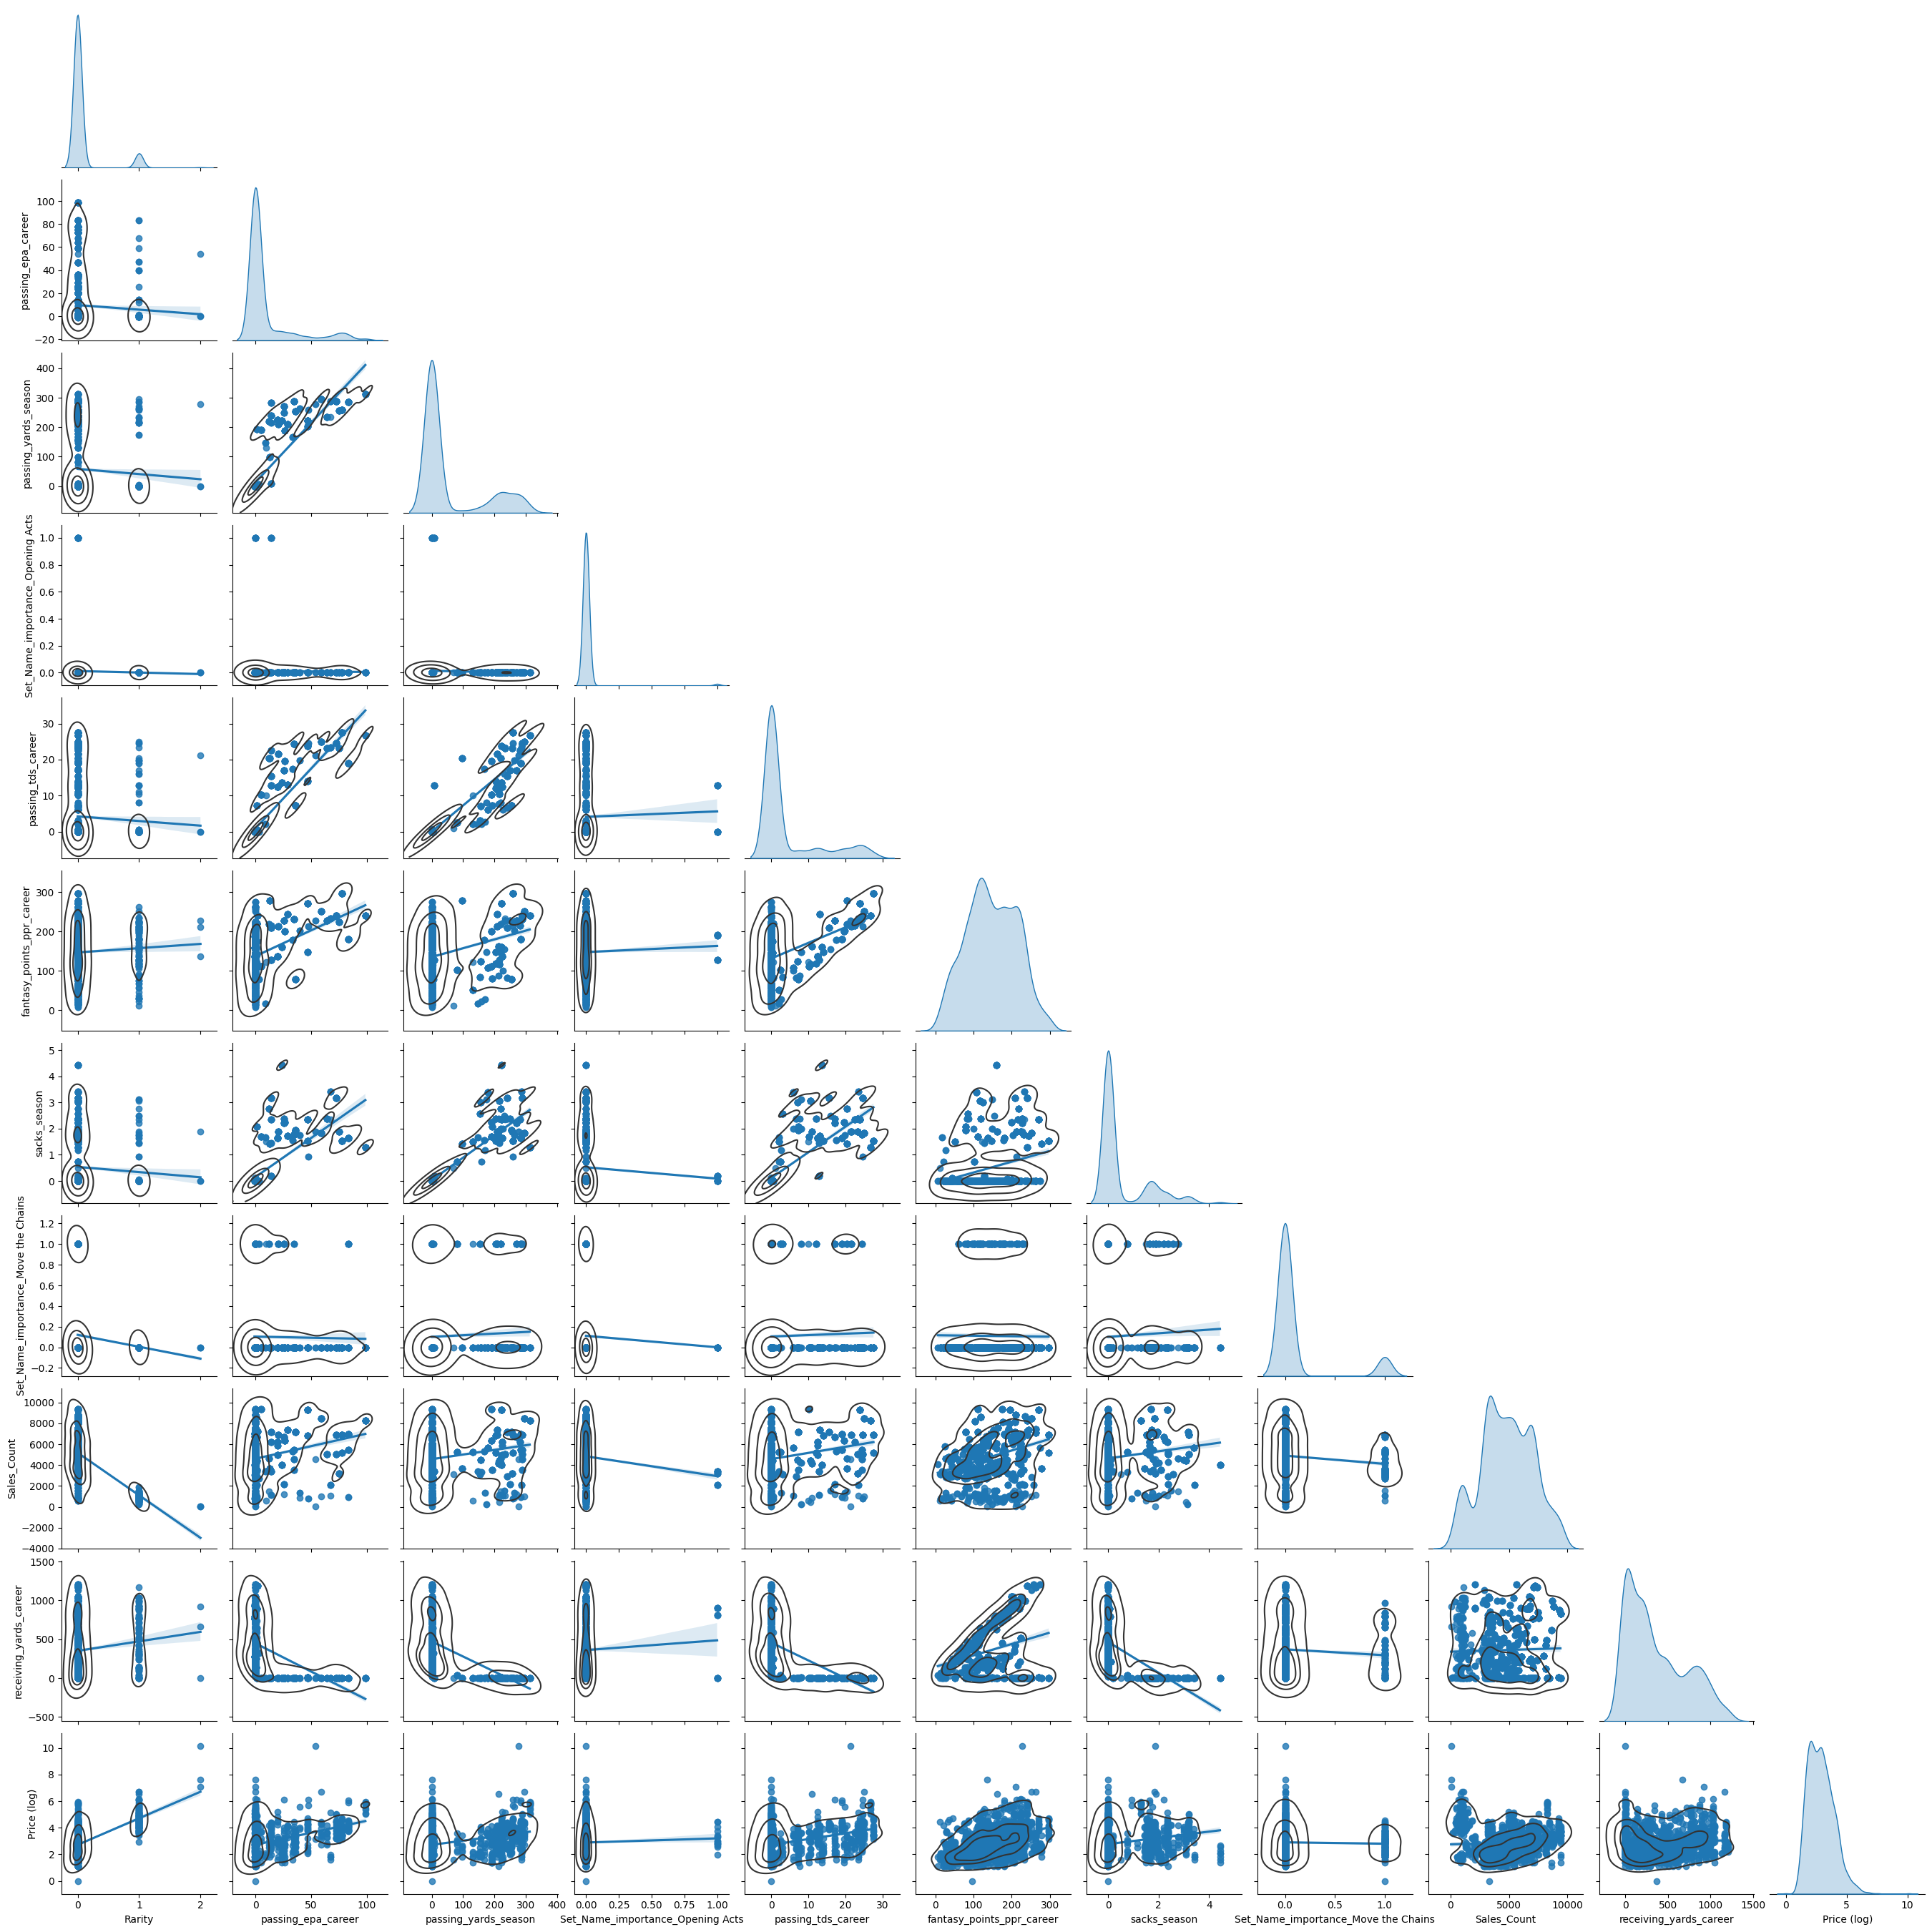

In [67]:
g=sns.pairplot(sampled_data[sorted_importance2.head(10)['index'].values.tolist()+["Price (log)"]],  corner=True, kind='reg', diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")


In [68]:
g.savefig('images/pairplot.png')

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/seaborn/axisgrid.py:1690: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


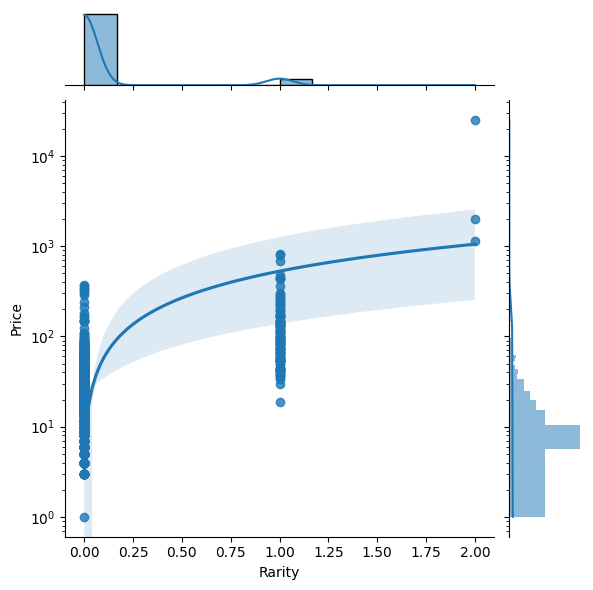

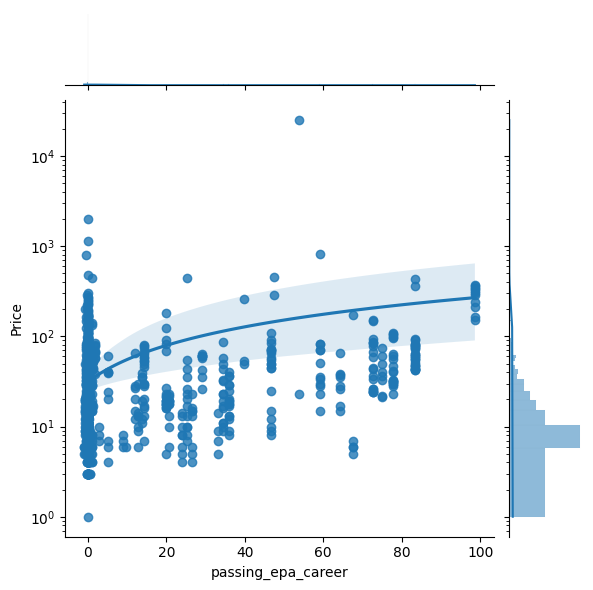

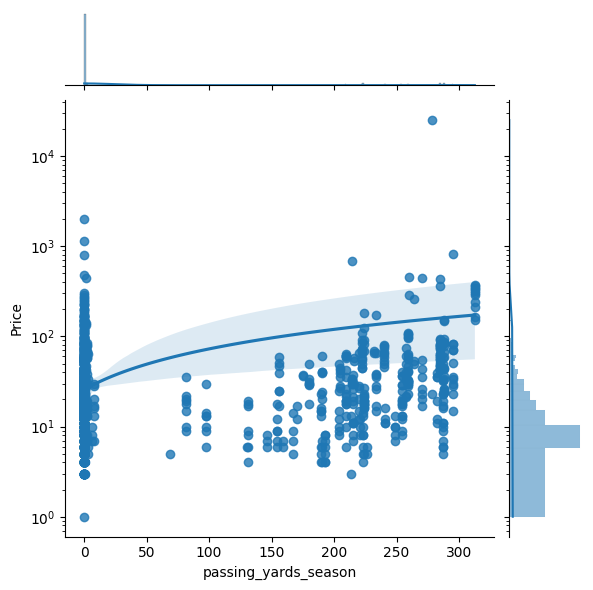

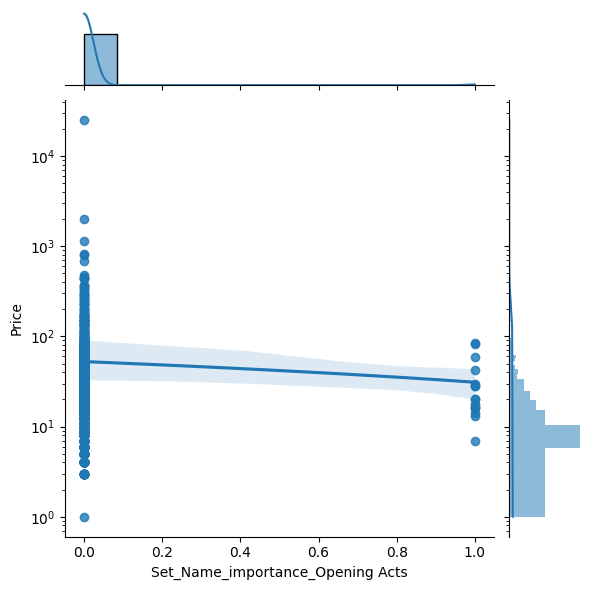

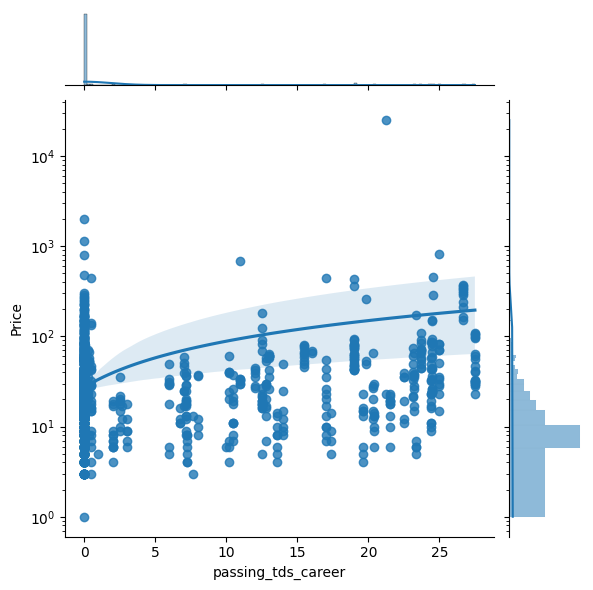

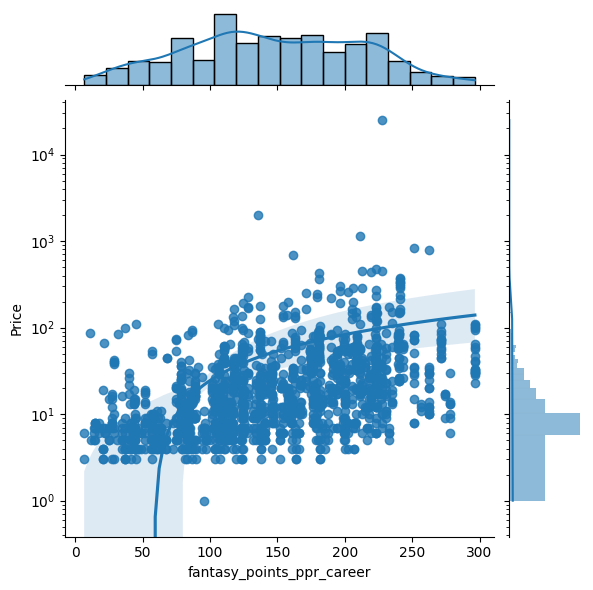

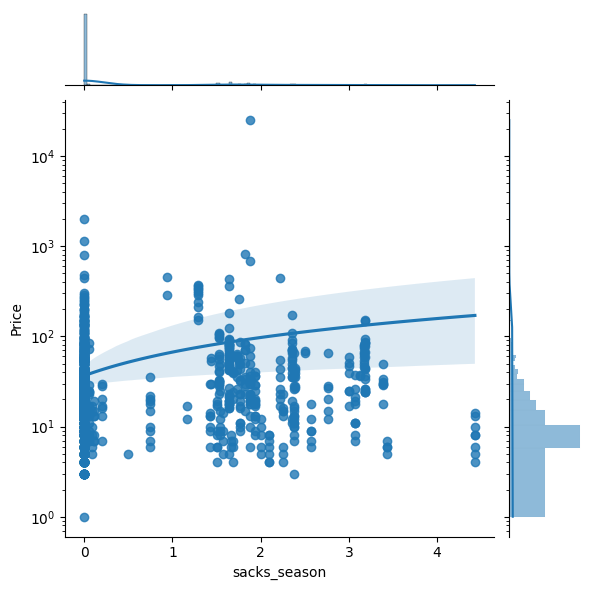

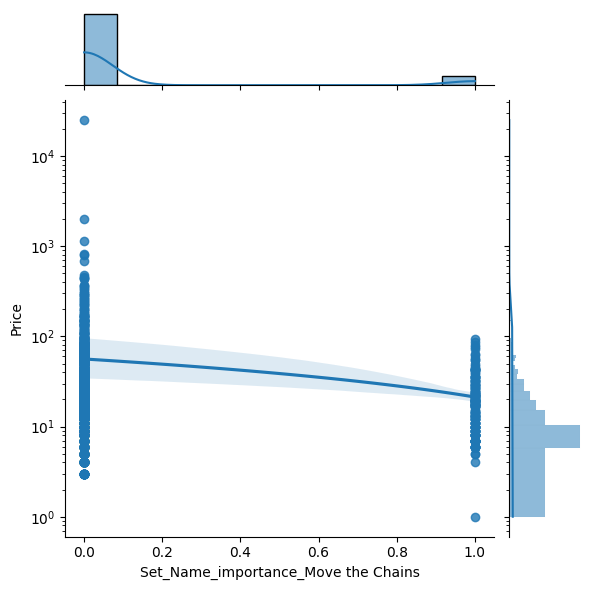

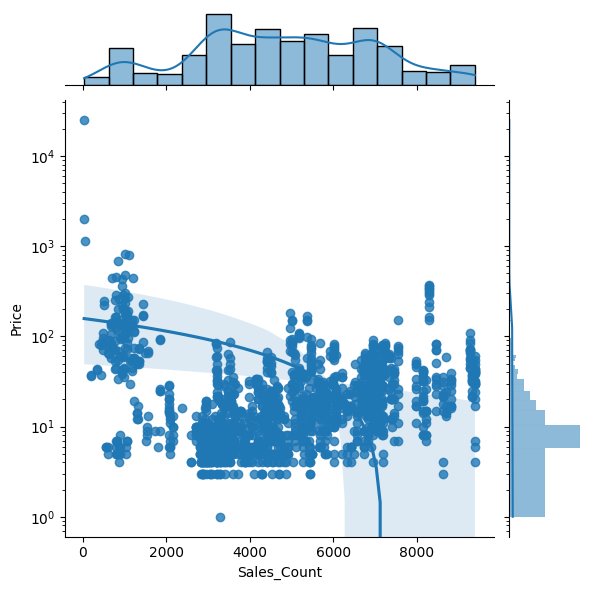

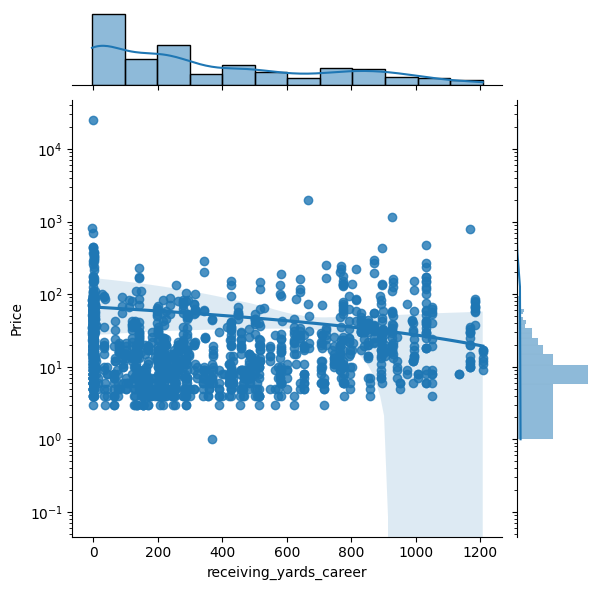

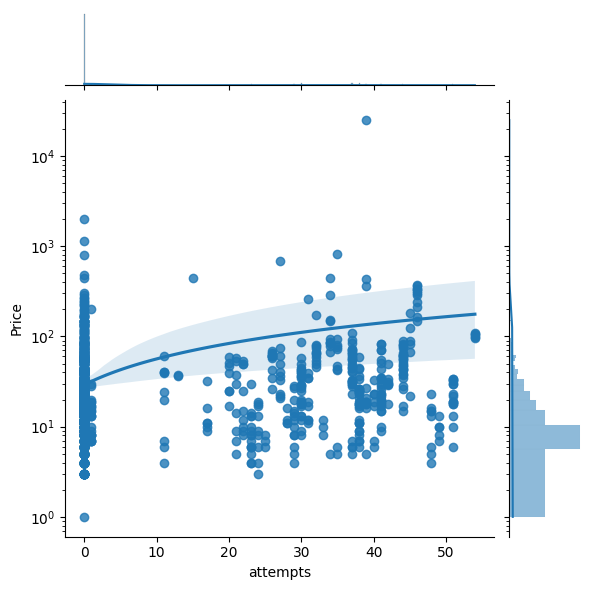

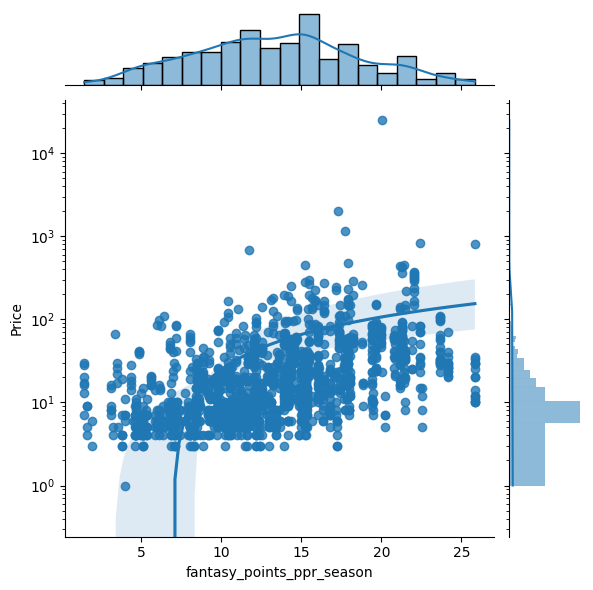

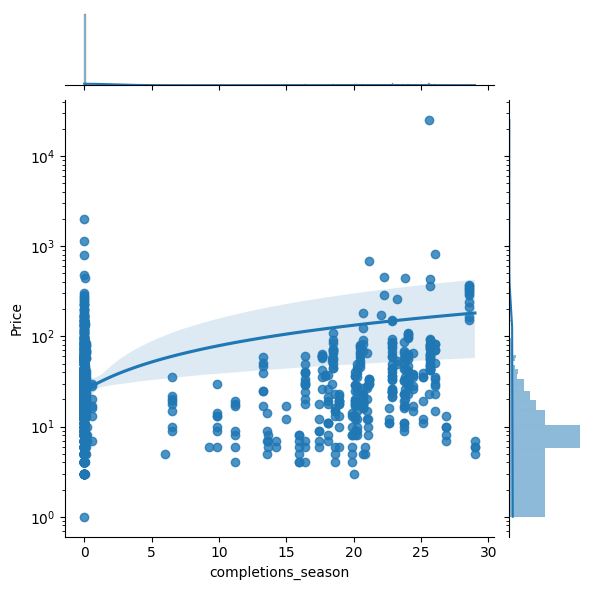

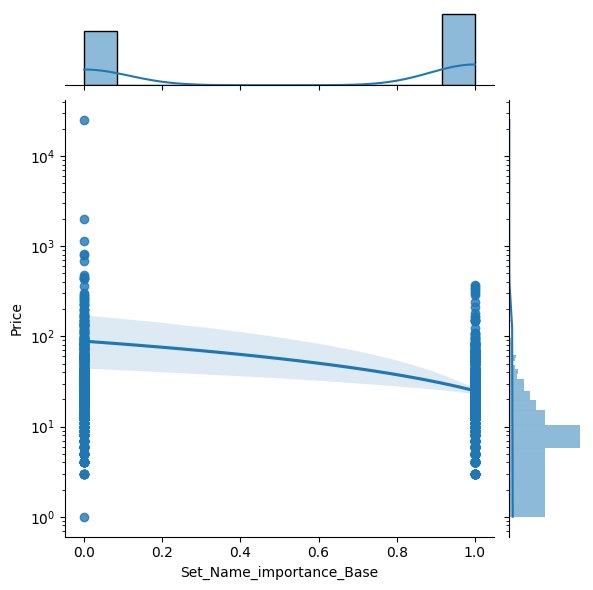

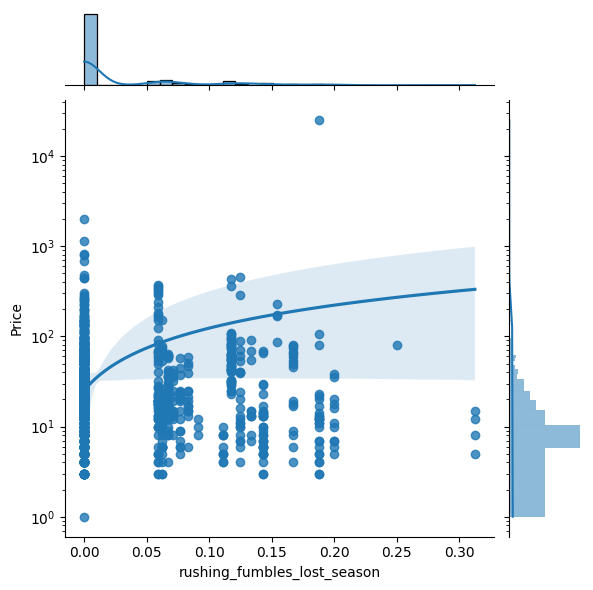

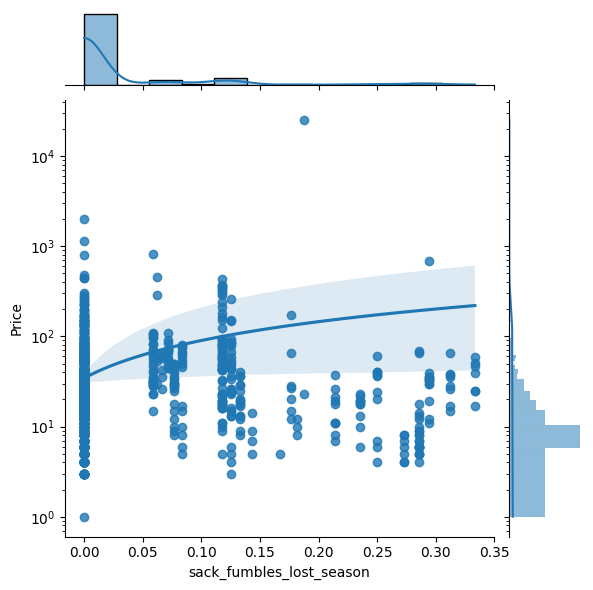

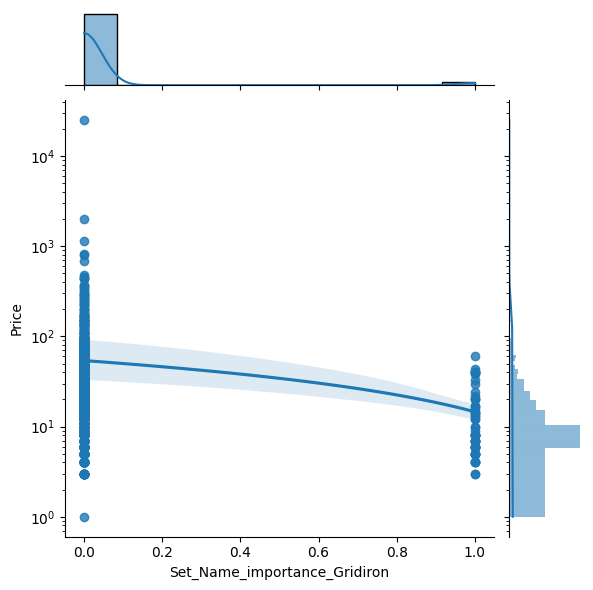

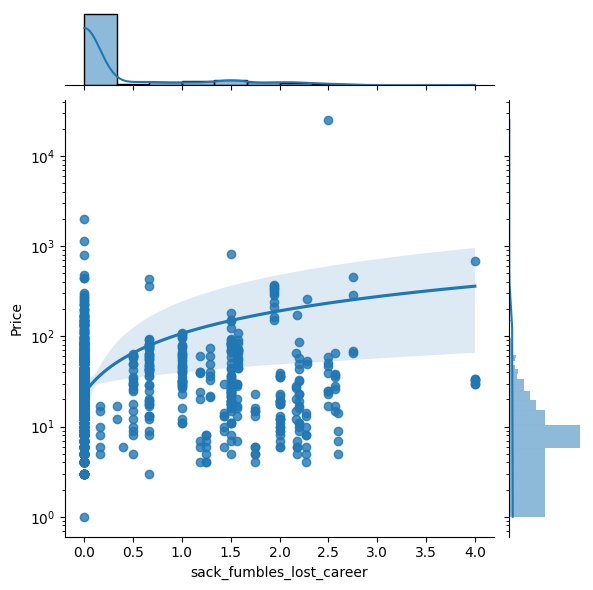

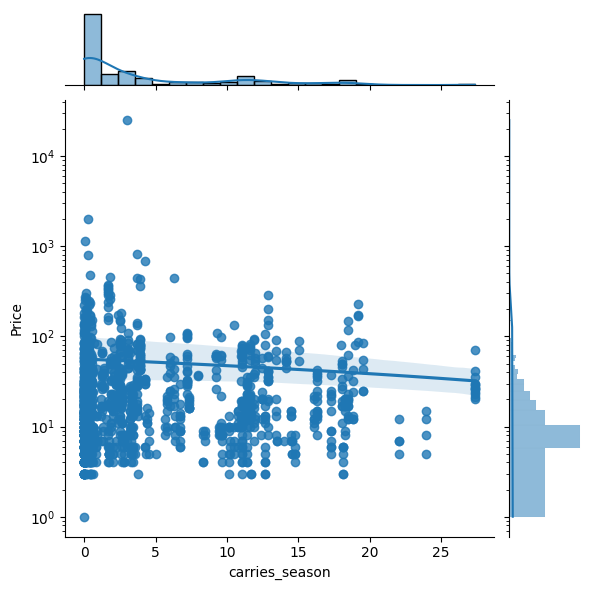

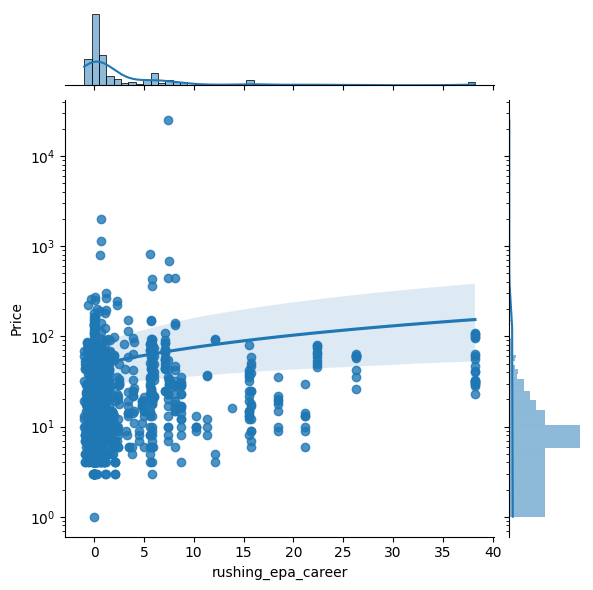

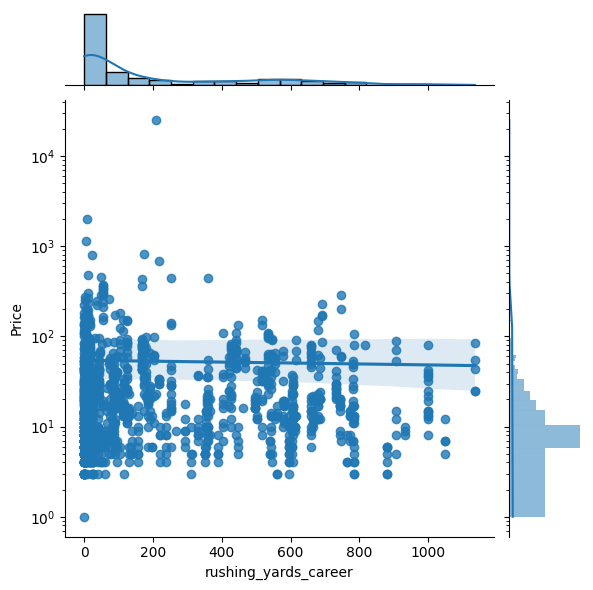

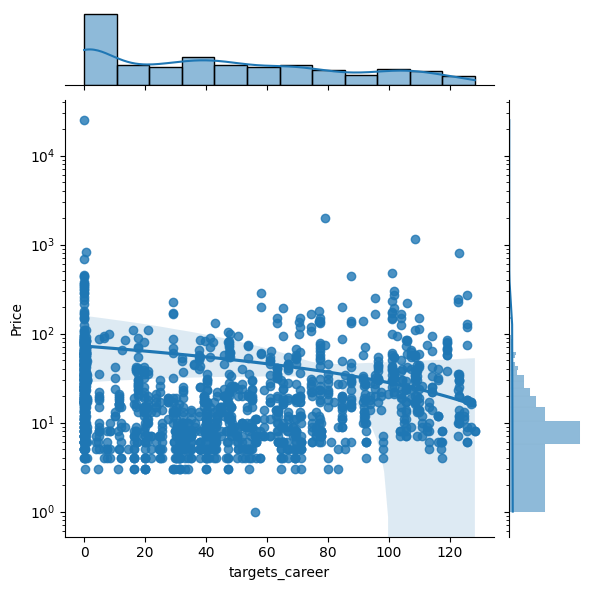

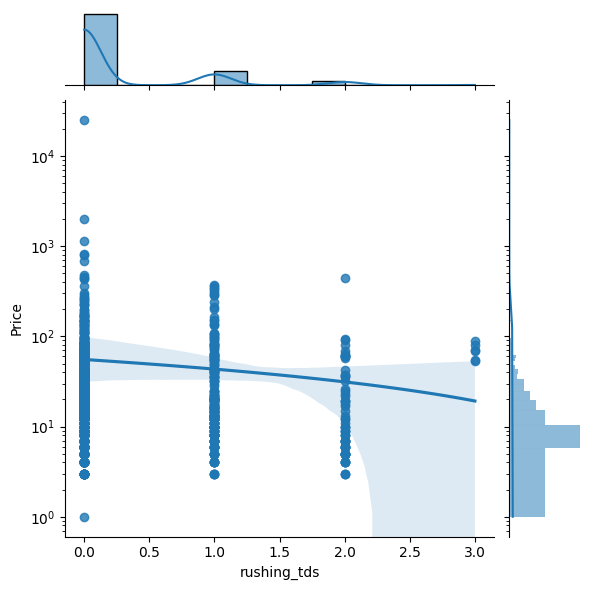

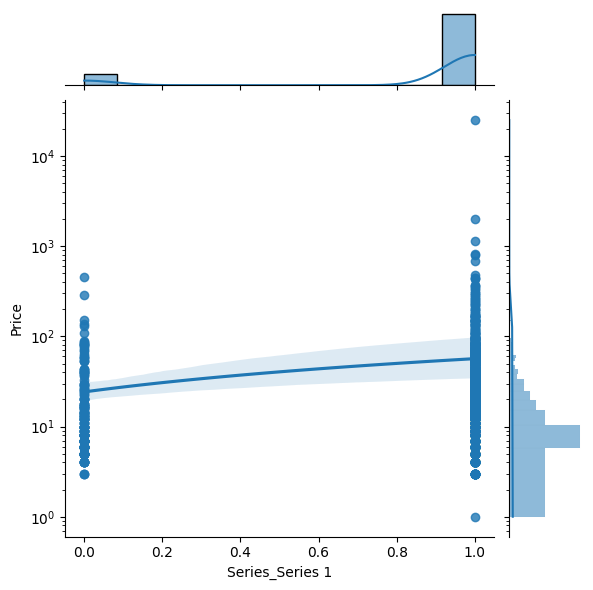

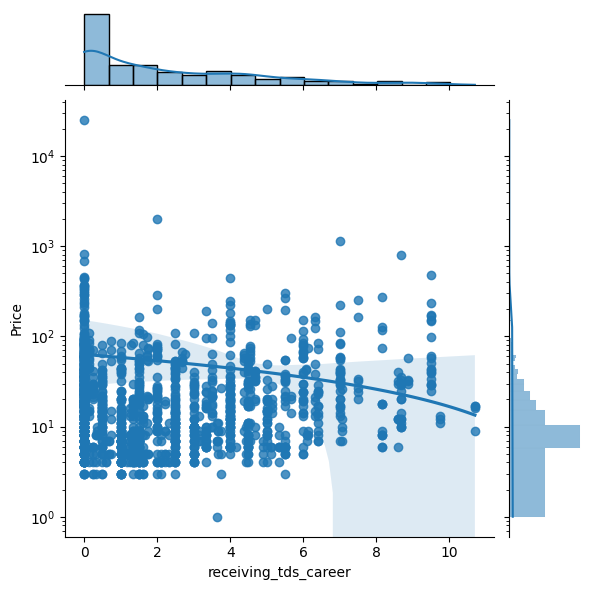

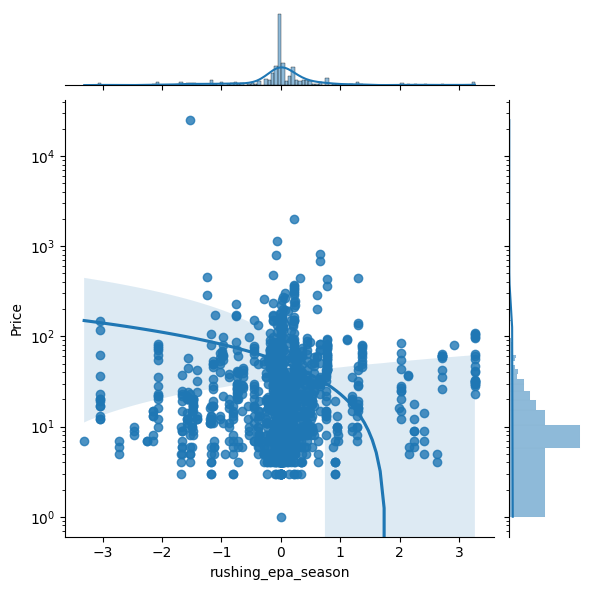

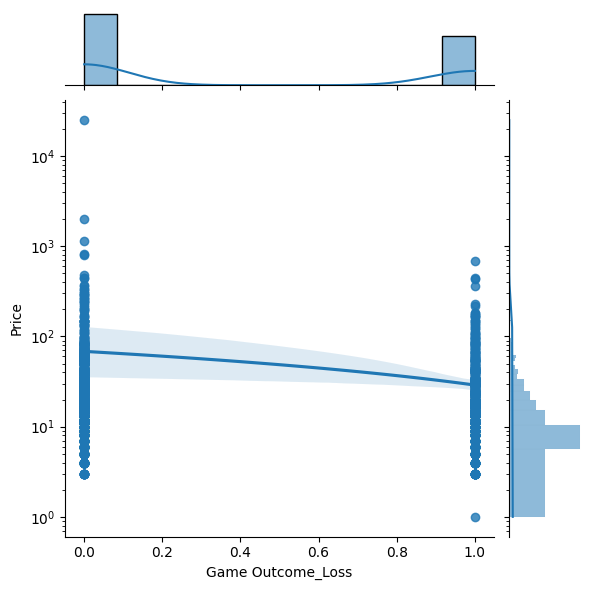

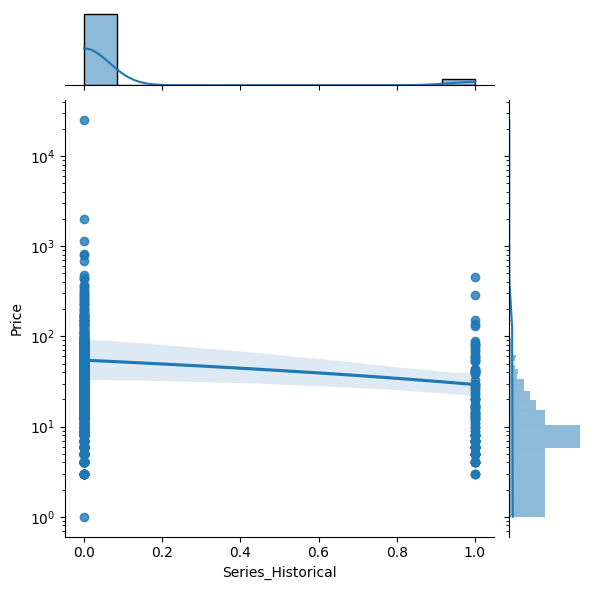

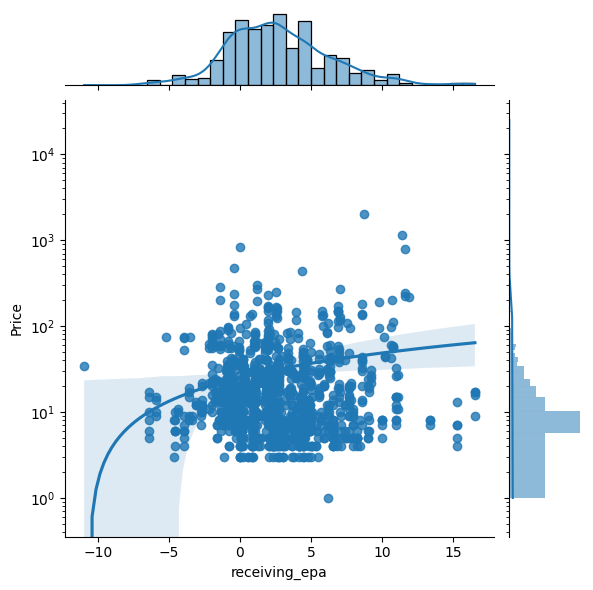

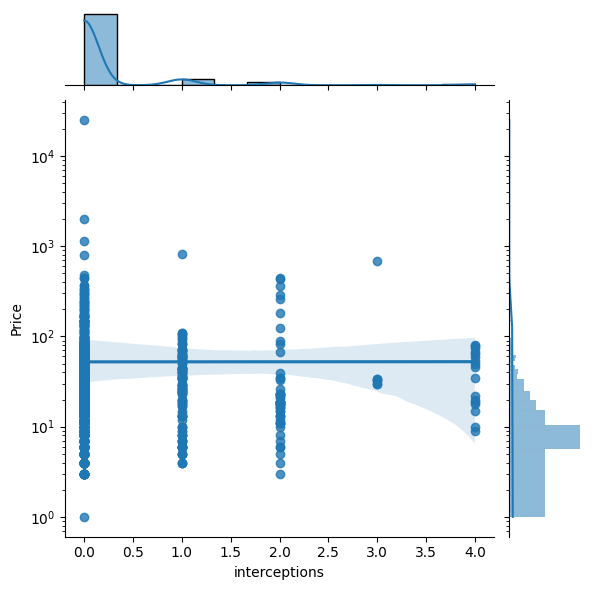

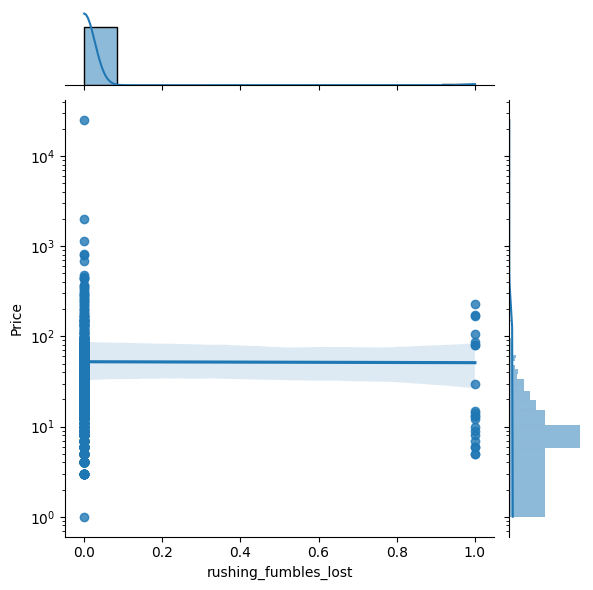

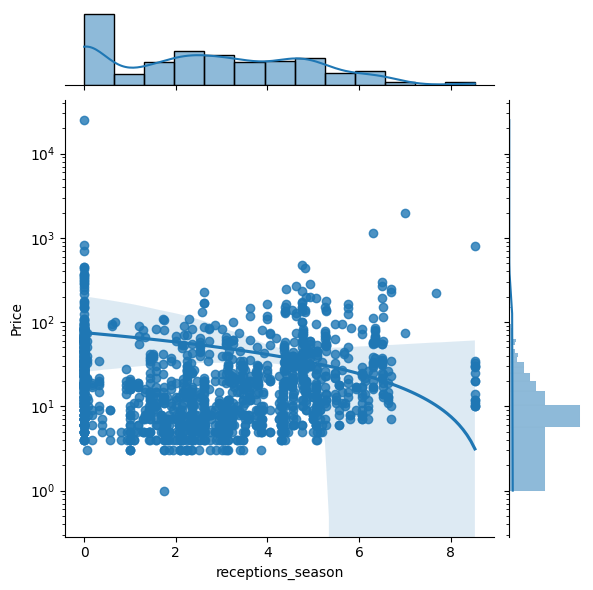

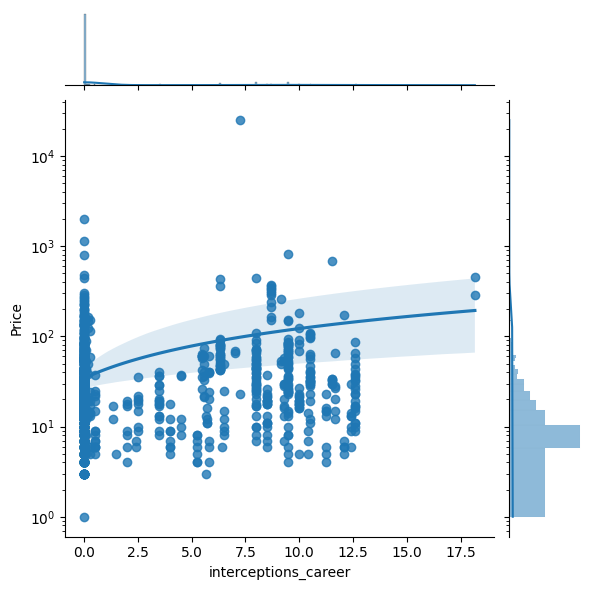

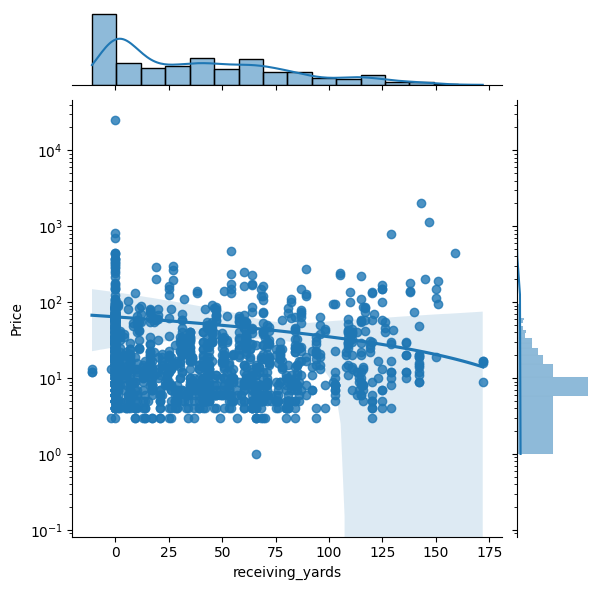

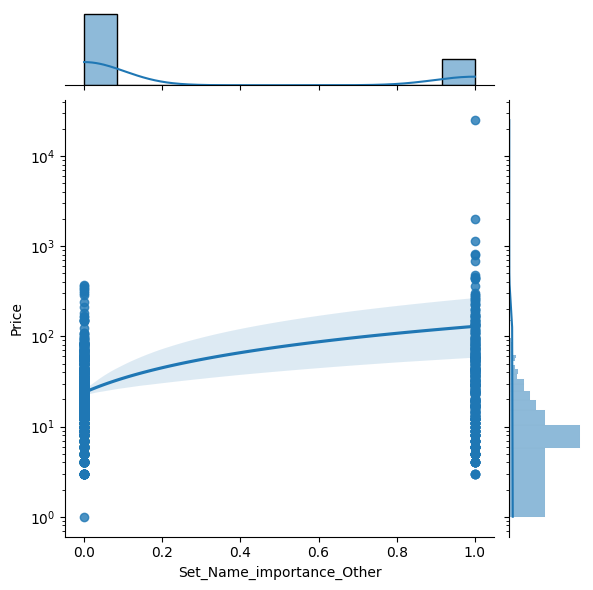

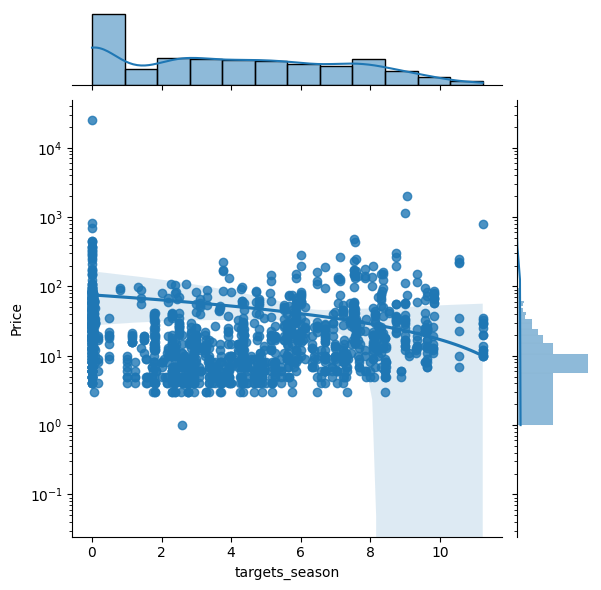

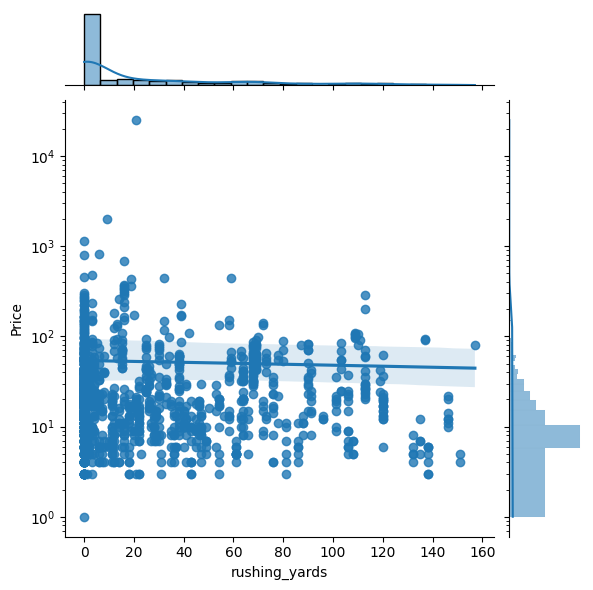

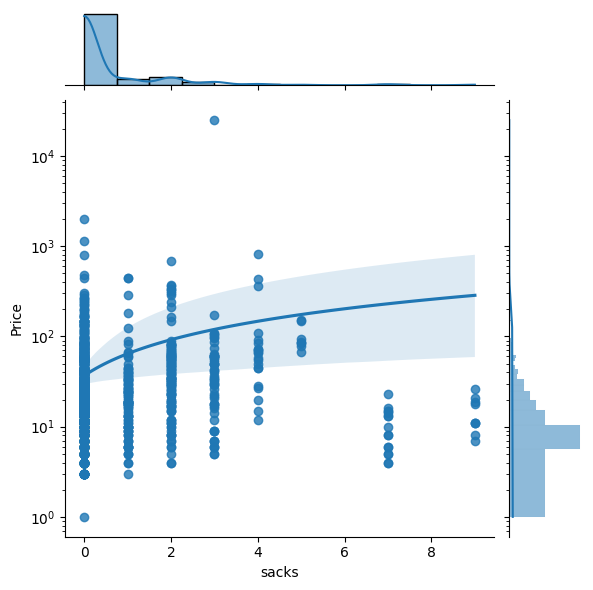

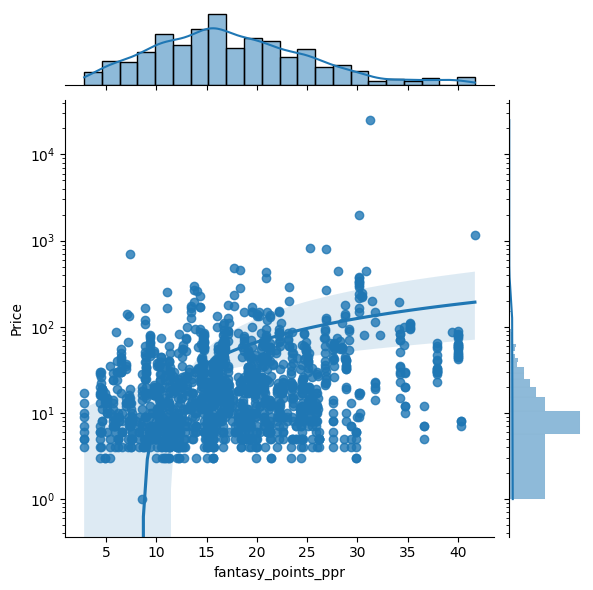

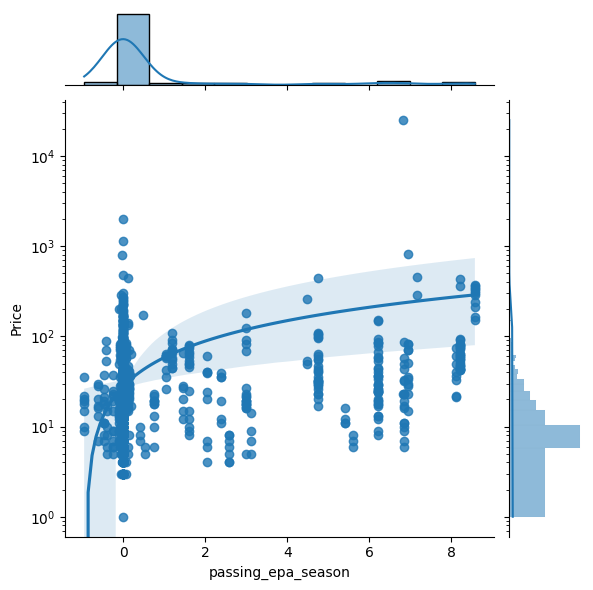

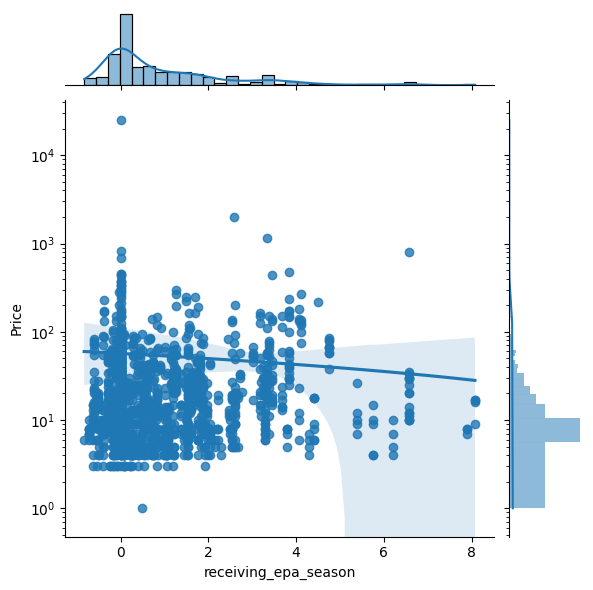

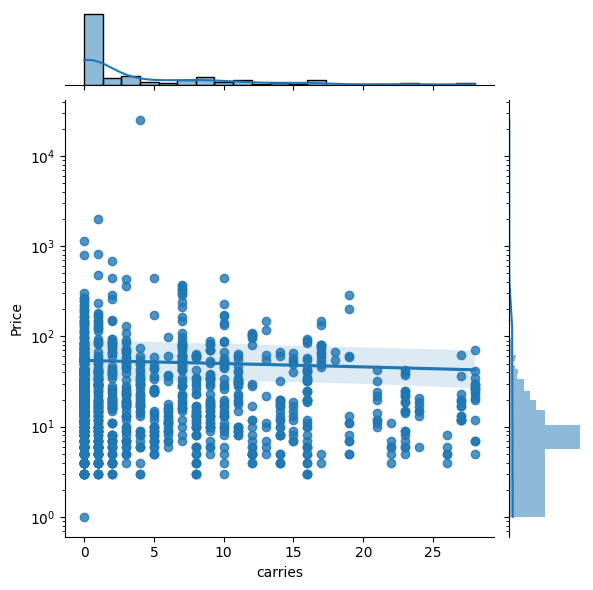

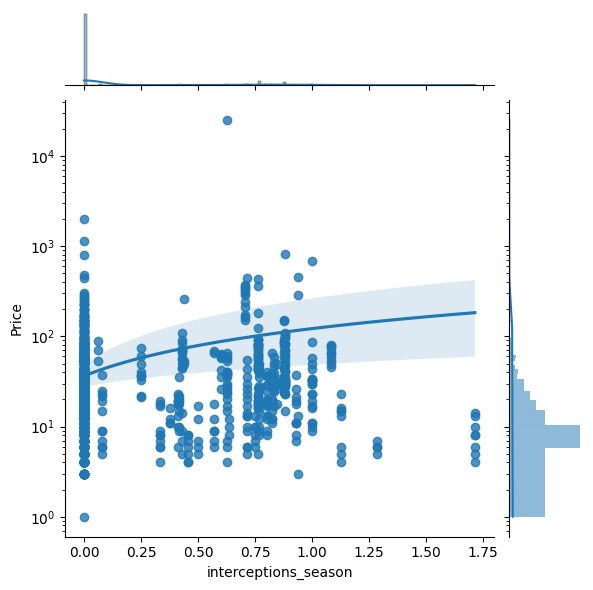

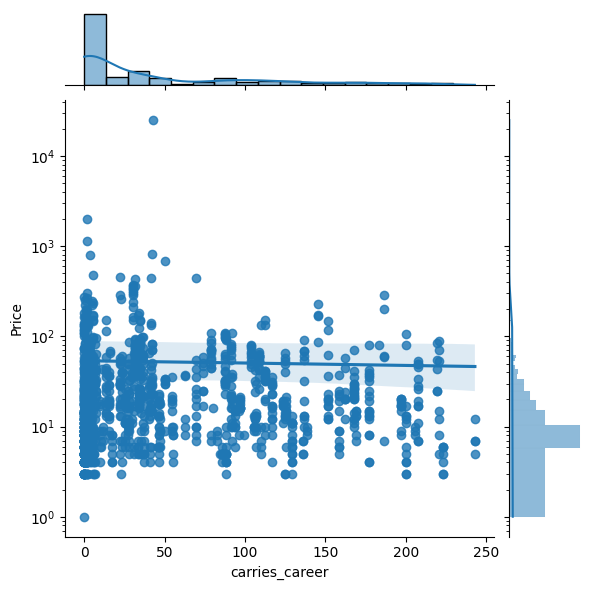

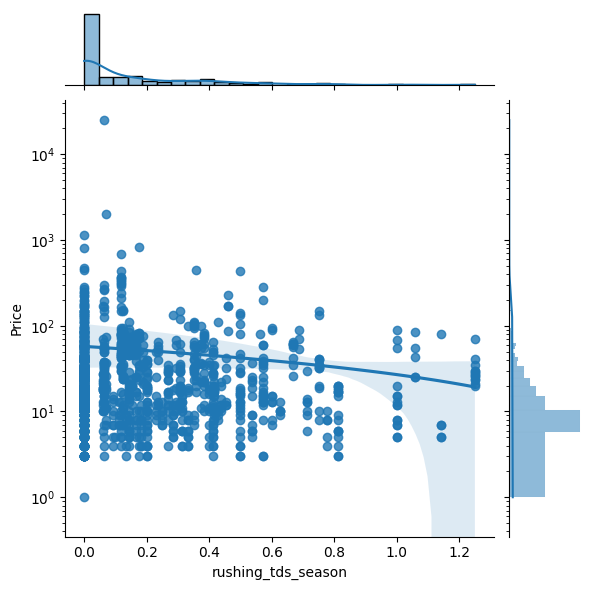

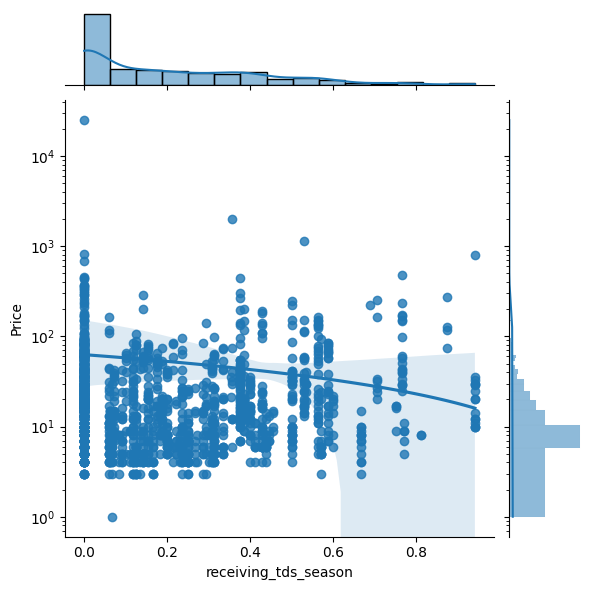

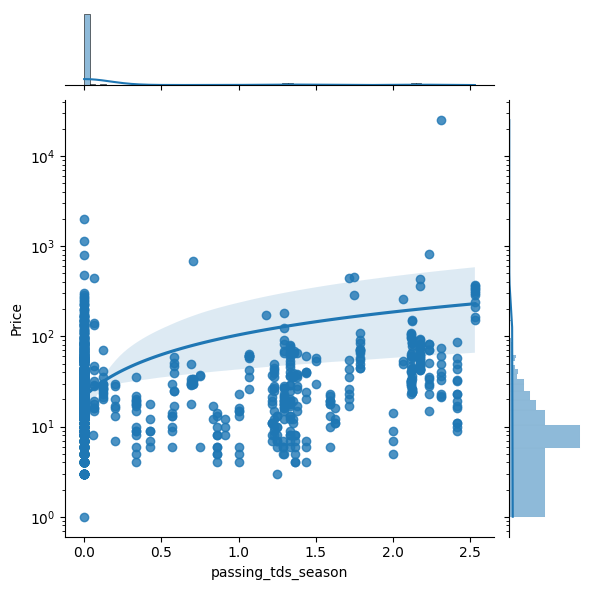

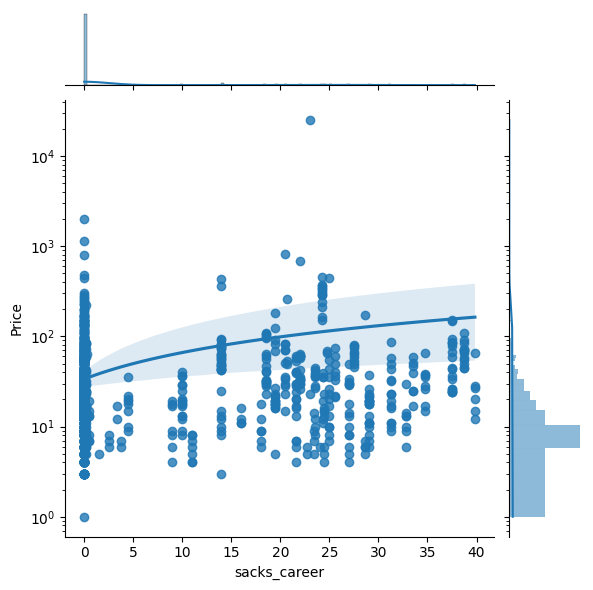

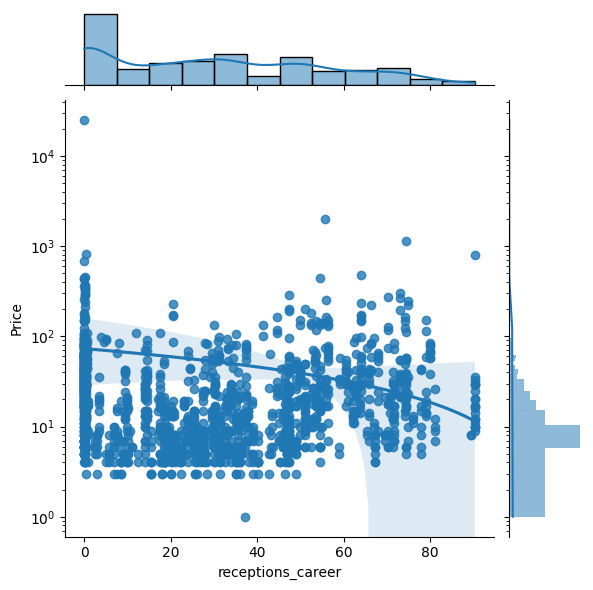

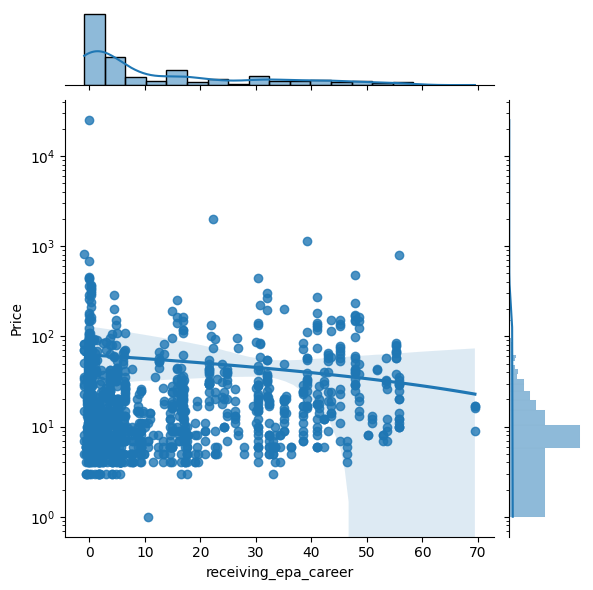

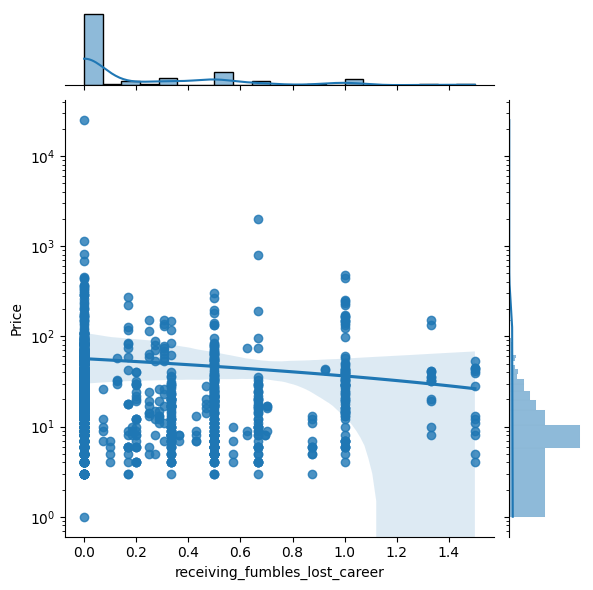

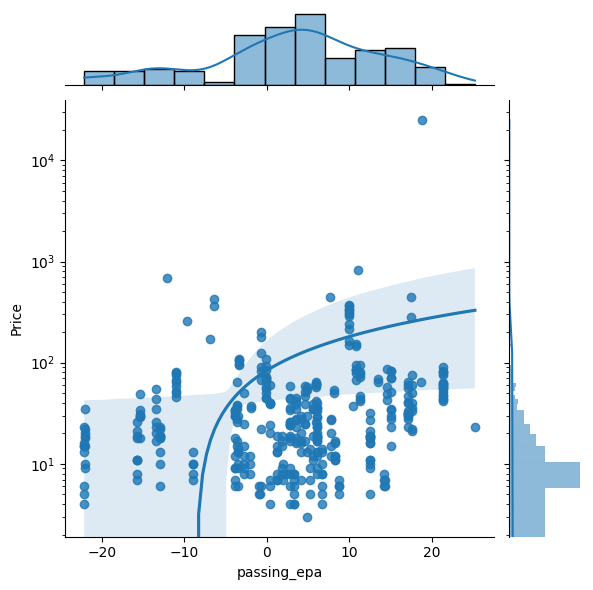

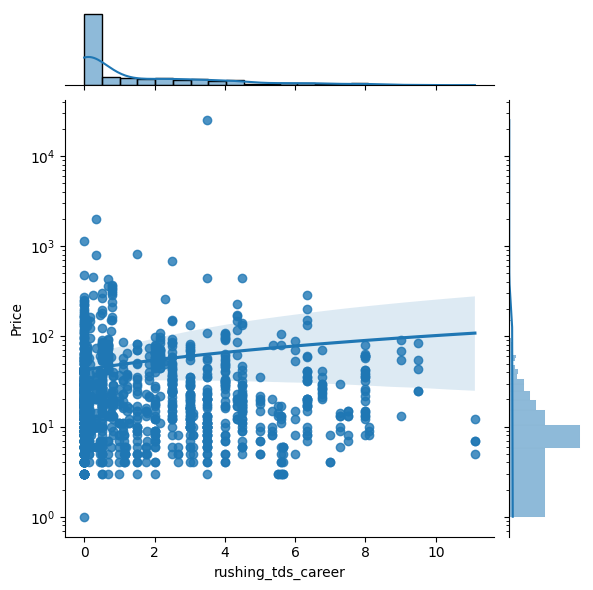

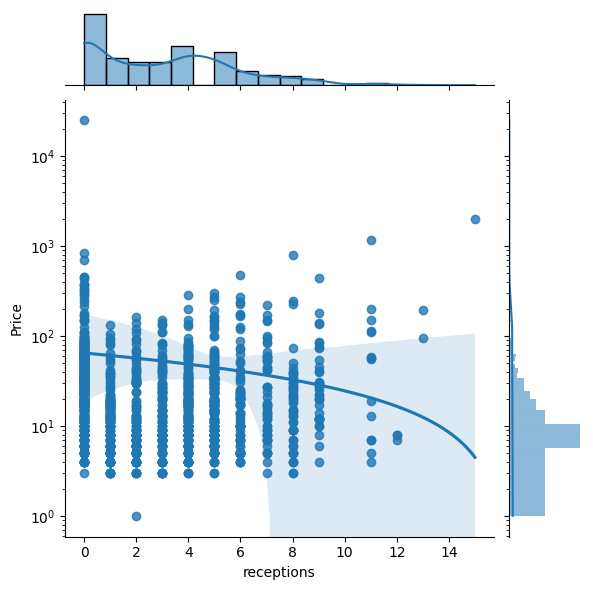

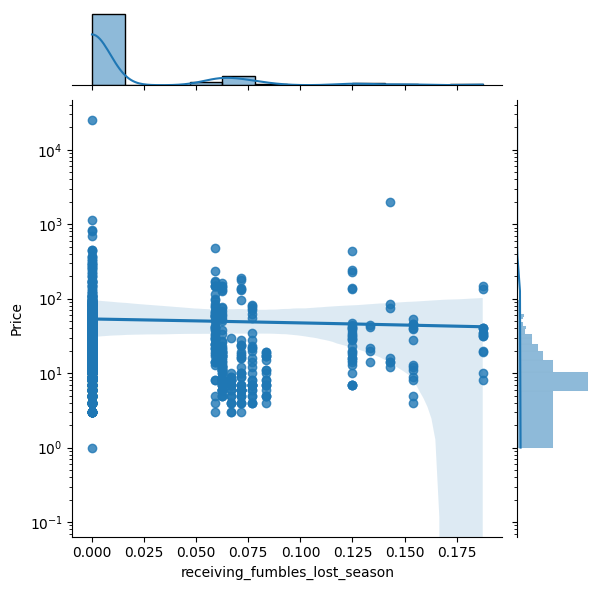

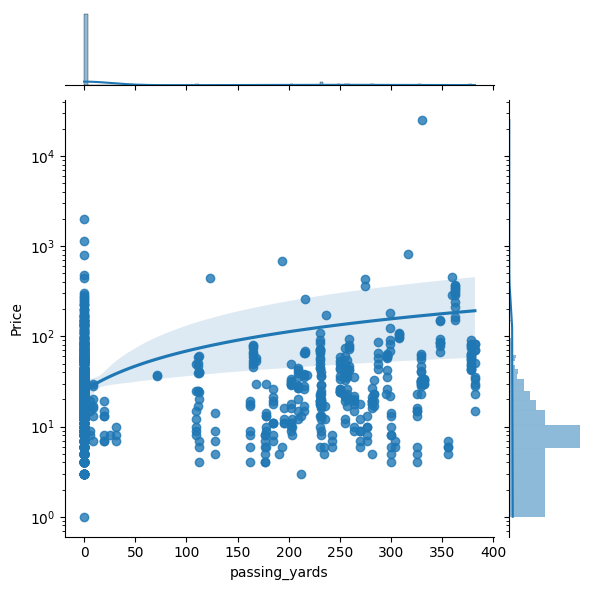

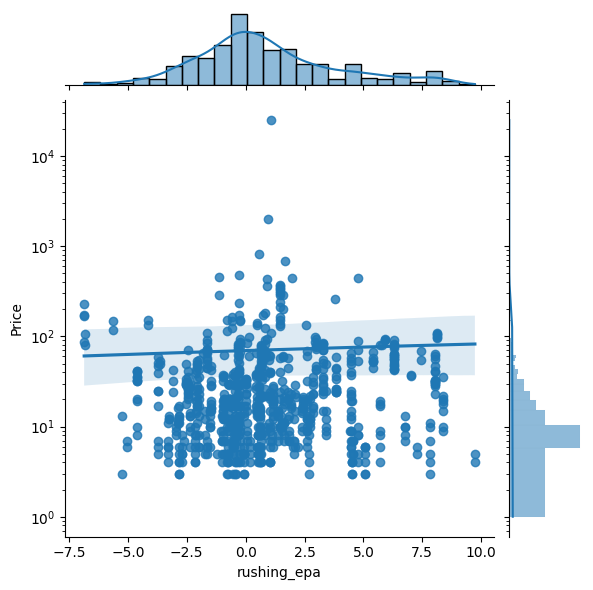

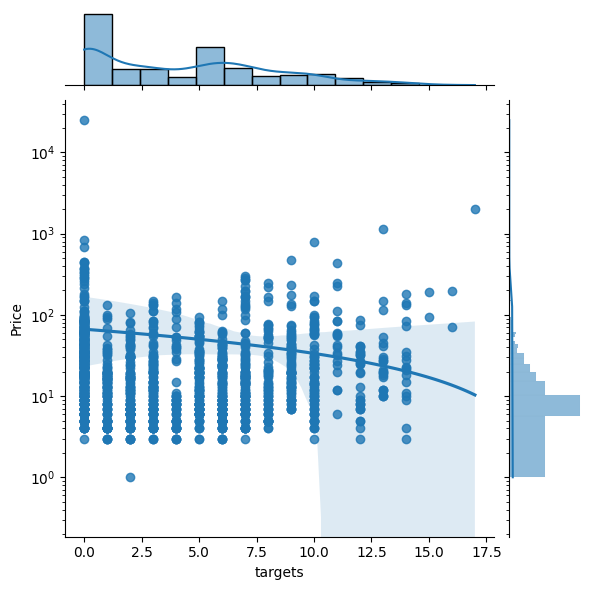

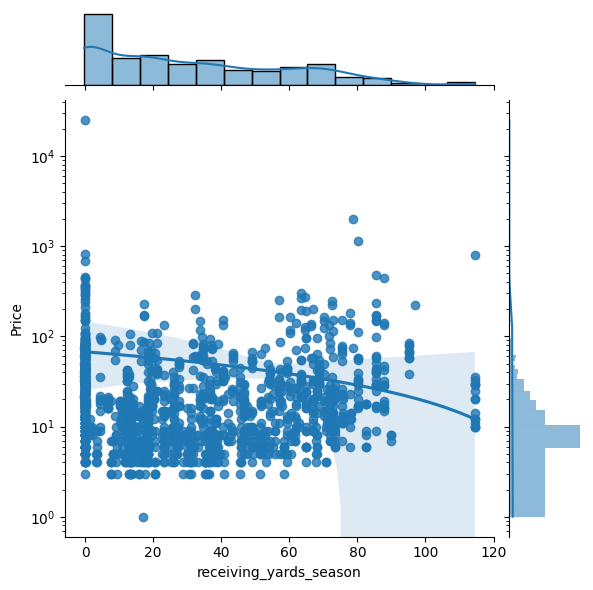

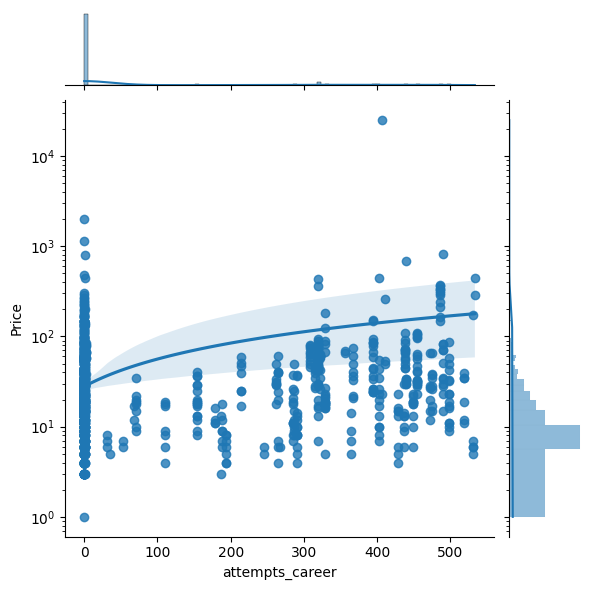

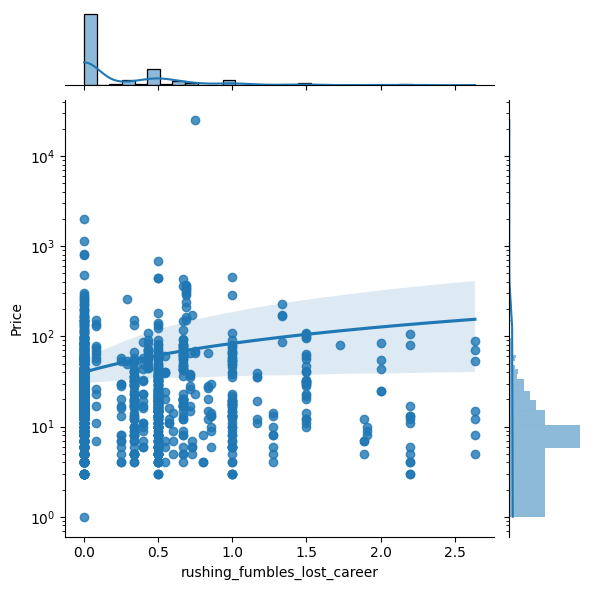

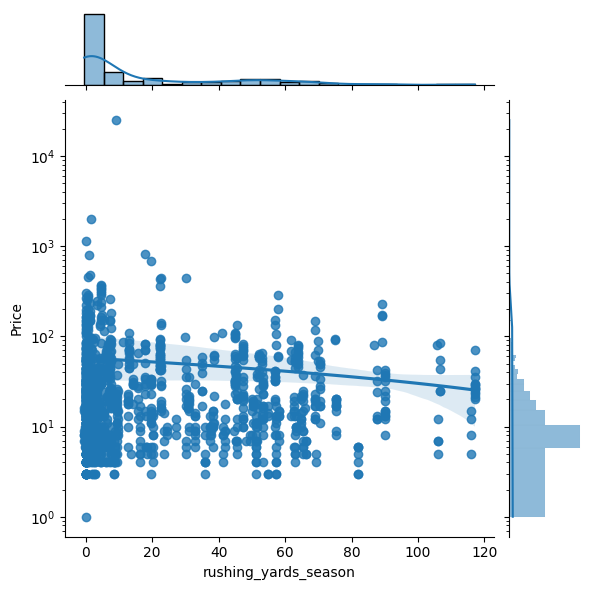

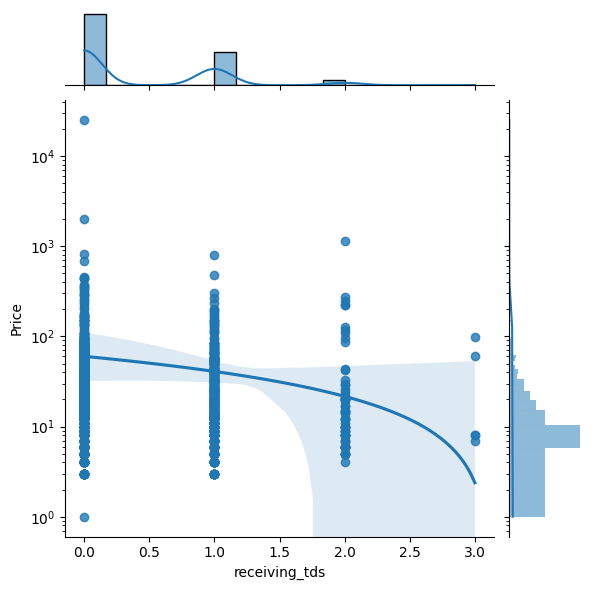

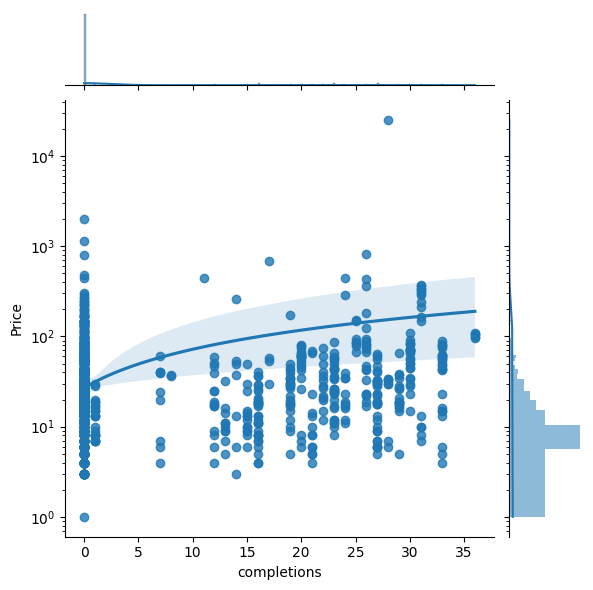

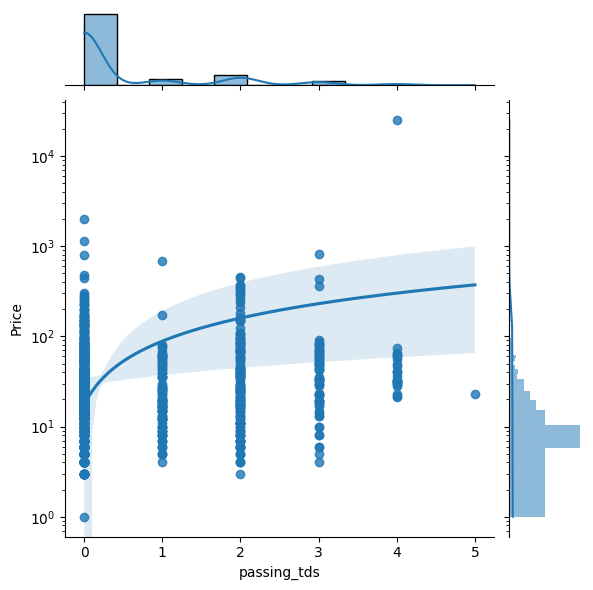

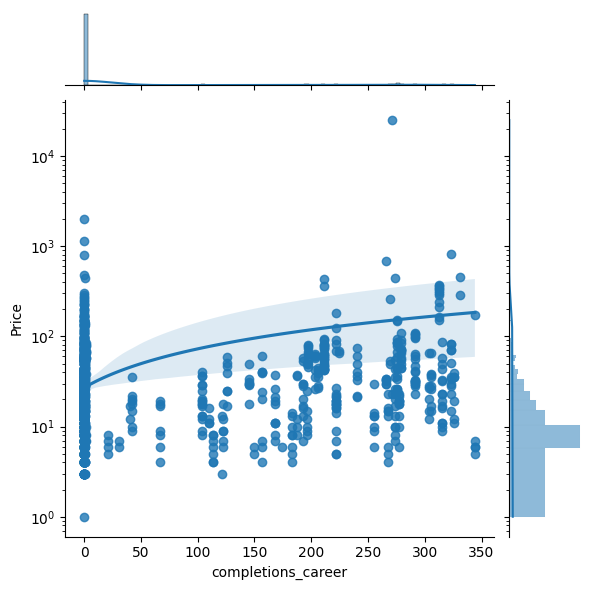

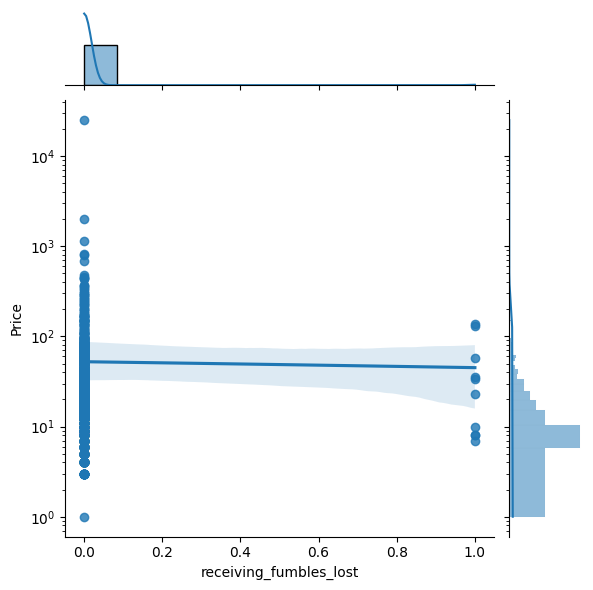

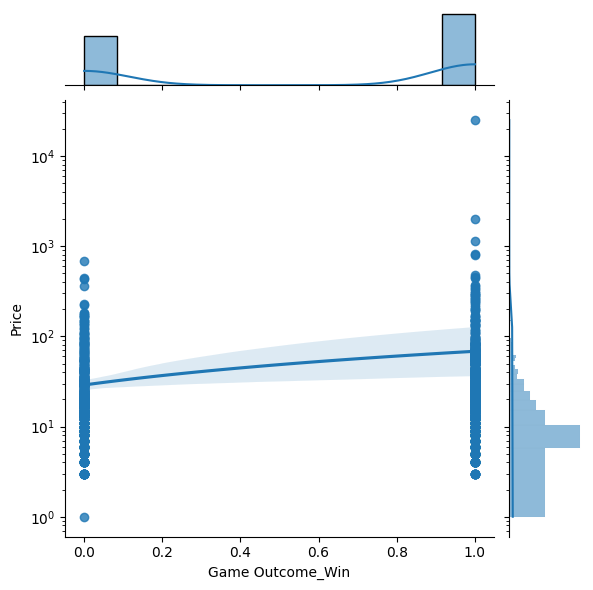

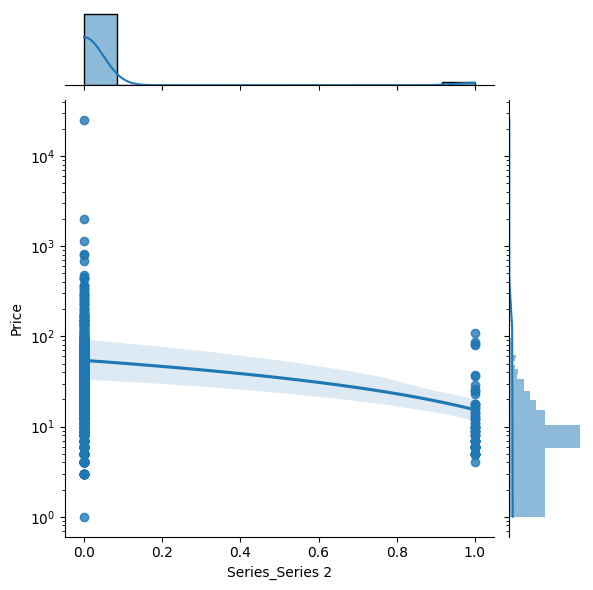

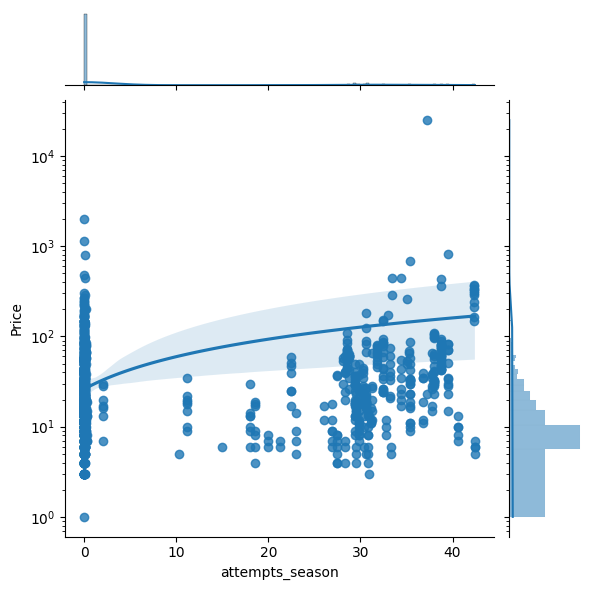

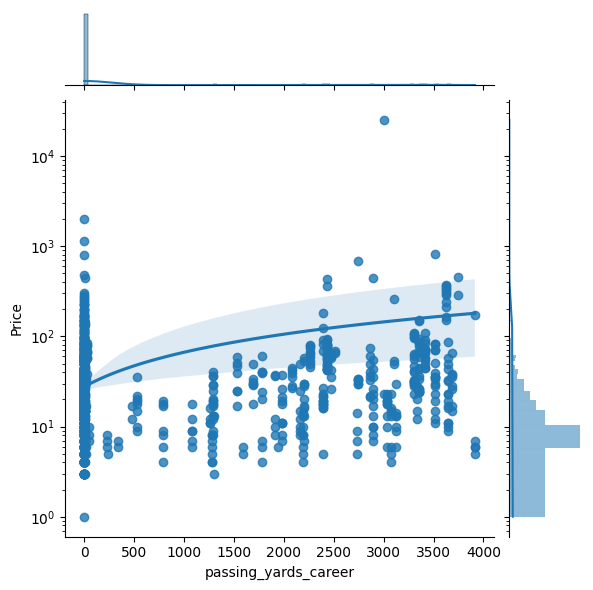

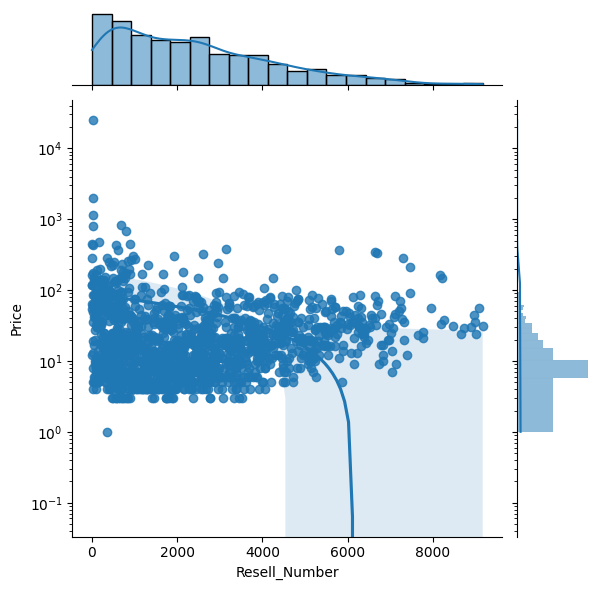

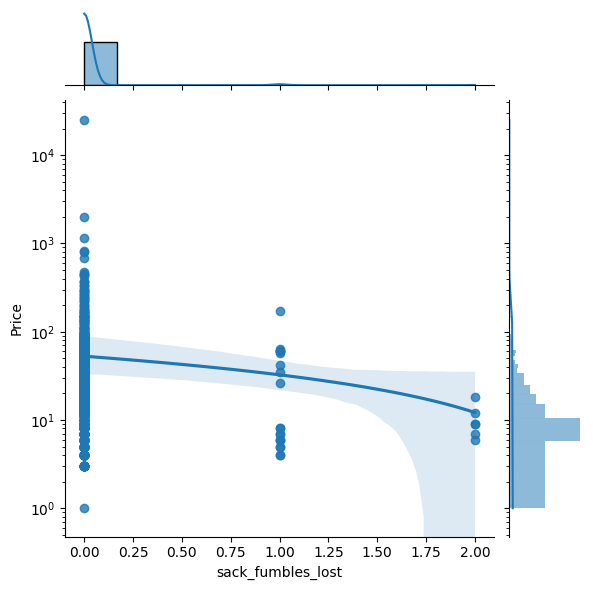

In [69]:
for i in sorted_importance2['index'].values:
    g=sns.jointplot(x=sampled_data[i], 
                    y=np.exp(sampled_data.rename(columns={"Price (log)":"Price"})["Price"]), kind="reg"
                   )
    g.ax_joint.set_yscale('log')
    g.savefig(f'images/ml/price_v_{i}.jpg')

In [70]:
plt.close('all')

In [62]:
from scipy.stats import spearmanr, ttest_ind

In [95]:
def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)
    return mae, mse, rmse,  r_squared, mape
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y.values.ravel(), scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score", "MAPE"])

In [97]:
# xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
# xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

mae, mse, rmse, r_squared, mape = evaluation(np.expm1(y_test.values.ravel()), np.expm1(predictions))
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("-"*30)
# rmse_cross_val = rmse_cv(xgb_model)
# print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "XGBRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,"MAPE": mape,}# "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 12.574511077372744
MSE: 6533.375929631622
RMSE: 80.8293011823783
R2 Score: 0.8090871276500597
MAPE: 0.3539032287156024
------------------------------


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<AxesSubplot: >

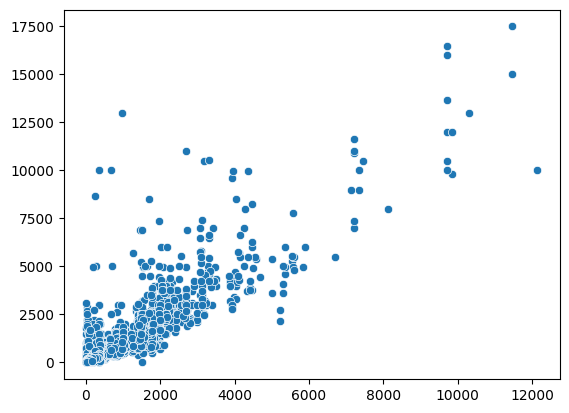

In [66]:
sns.scatterplot(x=np.expm1(predictions),  y=np.expm1(y_test.values.ravel()))

In [67]:
ttest_ind(predictions, y_test.values.ravel(), equal_var=False)

Ttest_indResult(statistic=0.48368566700387805, pvalue=0.6286091132709554)

In [68]:
spearmanr(predictions, y_test.values.ravel())

SpearmanrResult(correlation=0.8862684568497753, pvalue=0.0)

In [69]:
import shap

In [70]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [71]:
shap_values

.values =
array([[-1.8299776e-01, -2.5328618e-01,  2.3018806e-01, ...,
        -3.1954661e-02, -5.2601499e-03,  5.6151506e-03],
       [-1.8164097e-01, -2.5293896e-01,  2.3173091e-01, ...,
        -3.1954661e-02, -5.2601499e-03,  5.6675691e-03],
       [-1.8164146e-01, -2.5044990e-01,  2.2730181e-01, ...,
        -3.1954661e-02, -5.2601499e-03,  5.6645107e-03],
       ...,
       [ 1.8848264e+00,  2.5608951e-02,  2.3031665e-01, ...,
        -7.8608058e-03, -1.6980359e-03, -1.3319288e-02],
       [ 1.8848217e+00,  2.5536271e-02,  2.3017867e-01, ...,
        -7.8608058e-03, -1.6980359e-03, -1.3319288e-02],
       [ 1.8848217e+00,  2.5534892e-02,  2.3018527e-01, ...,
        -7.8608058e-03, -1.6980359e-03, -1.3319288e-02]], dtype=float32)

.base_values =
array([2.9920964, 2.9920964, 2.9920964, ..., 2.9920964, 2.9920964,
       2.9920964], dtype=float32)

.data =
array([[ 0.        , -0.19956345, -5.18058404, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.1995

In [98]:
for name, data in [
    # ('X', X),
    # ('X_test', X_test),
    # ('X_train', X_train),
    # ('y', y),
    # ('y_test', y_test),
    # ('y_train', y_train),
    # ('predictions', pd.DataFrame(predictions, columns=['Price']))
    ('model_evaluation_rescaled', models),
    ('prediction_rescaled', pd.DataFrame( np.expm1(predictions), columns=['Price'])),
    ('y_test_rescaled', pd.DataFrame(np.expm1(y_test.values.ravel()), columns=['Price'])),
]:
    data.to_csv(f"{name}.csv", index=False)


In [106]:
X_samp = X.sample(frac=0.025, random_state=1234)

In [107]:
len(X_samp)

30521

In [108]:
shap_samp = shap_values[X_samp.index.values]

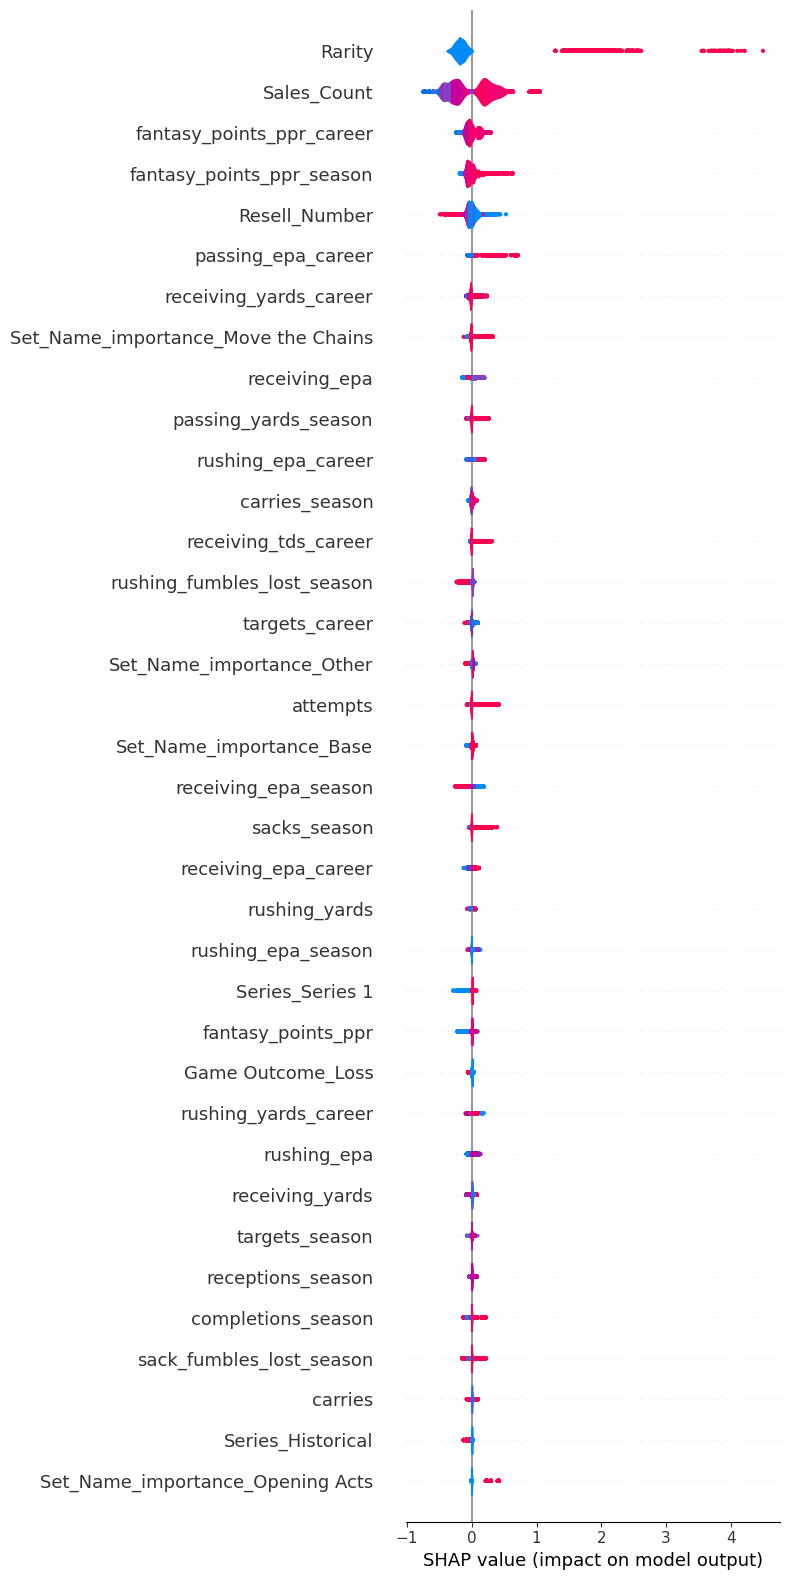

In [110]:
summary = shap.summary_plot(
    shap_samp, 
    X_samp,
    max_display=36,
    color_bar=False, # causes error
    plot_type='violin',
    # show=False,
)

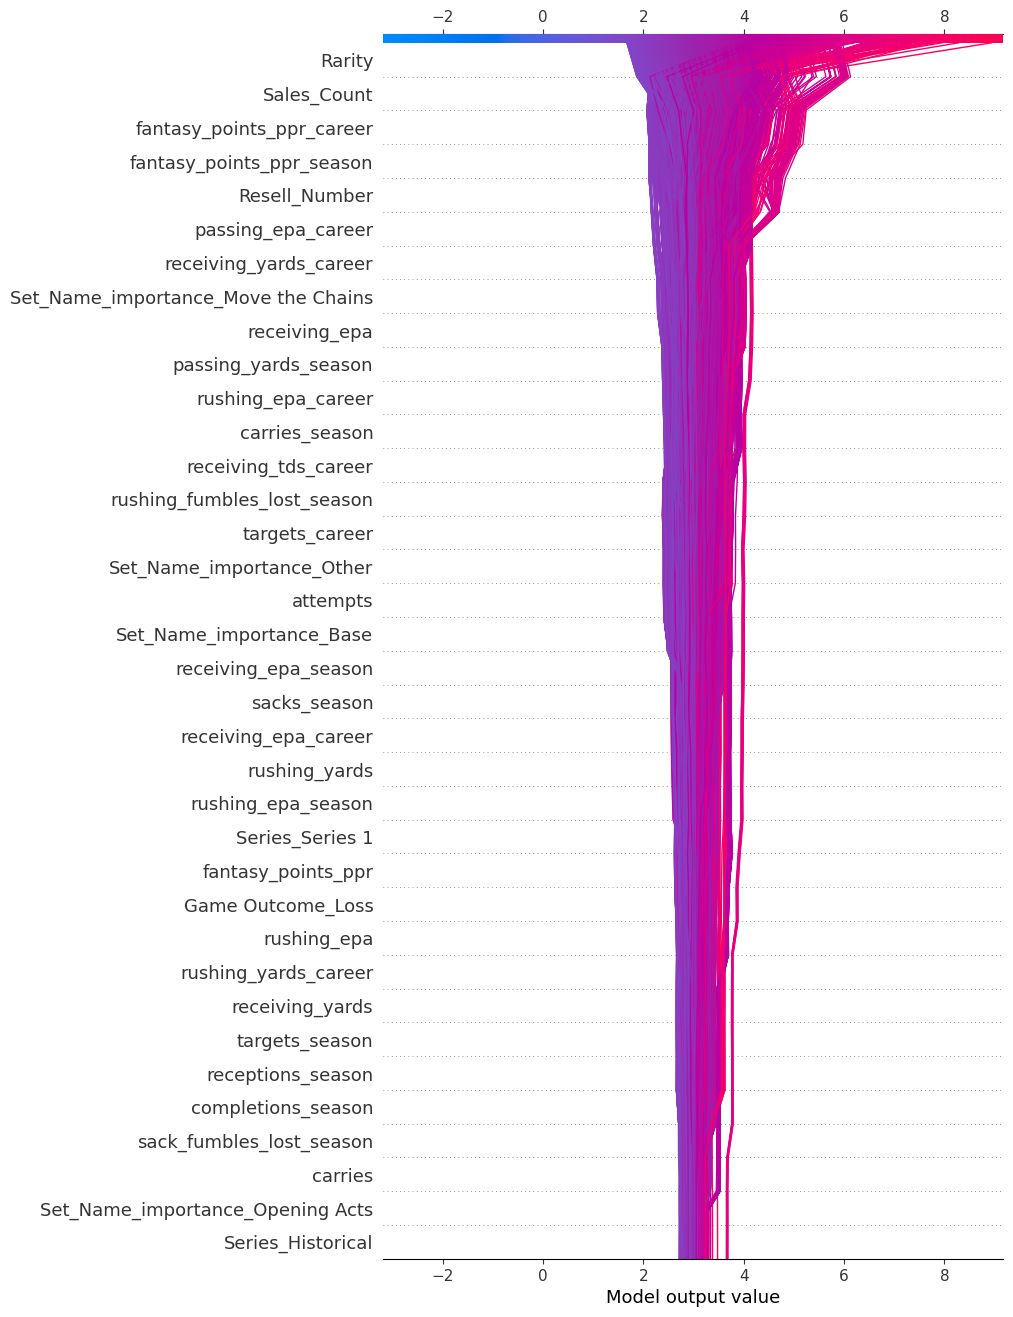

In [115]:
X_samp_small = X.sample(frac=0.01, random_state=1234)
shap_samp_small = shap_values[X_samp_small.index.values]
shap.decision_plot(
    explainer.expected_value, 
    shap_samp_small.values, 
    X_samp_small, 
    feature_display_range=slice(-1, -37, -1), ignore_warnings=True)

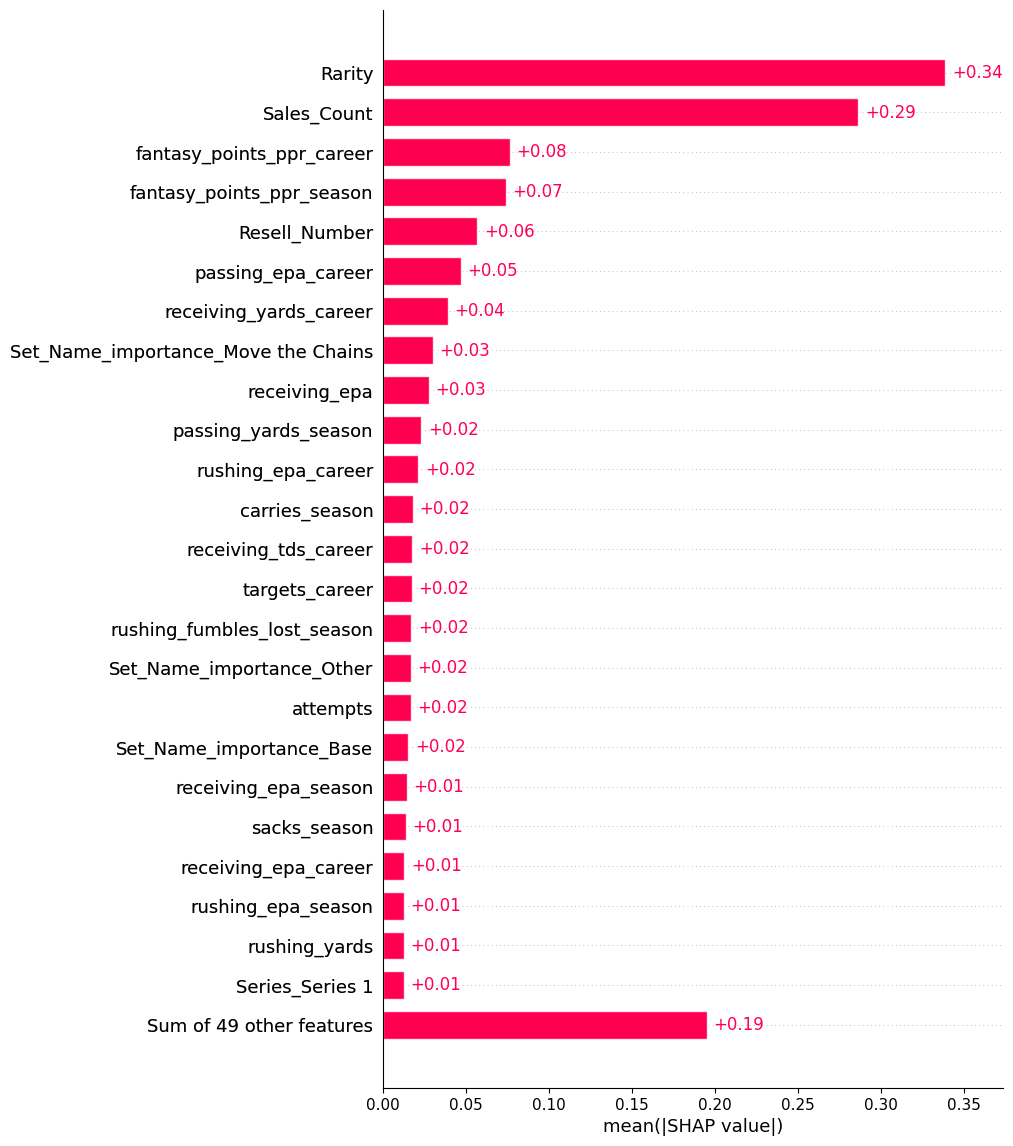

In [119]:
shap.plots.bar(shap_values, max_display=25)

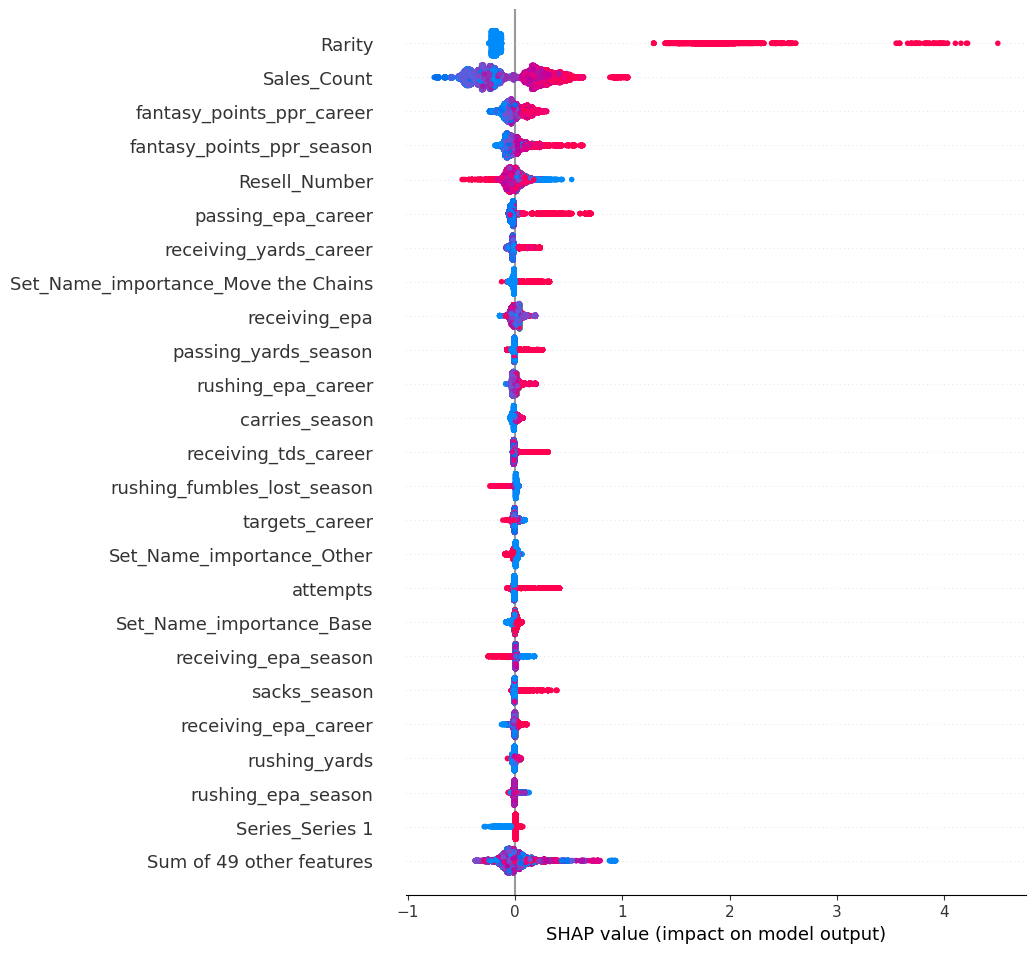

In [120]:
shap.plots.beeswarm(shap_samp, max_display=25, color_bar=False)

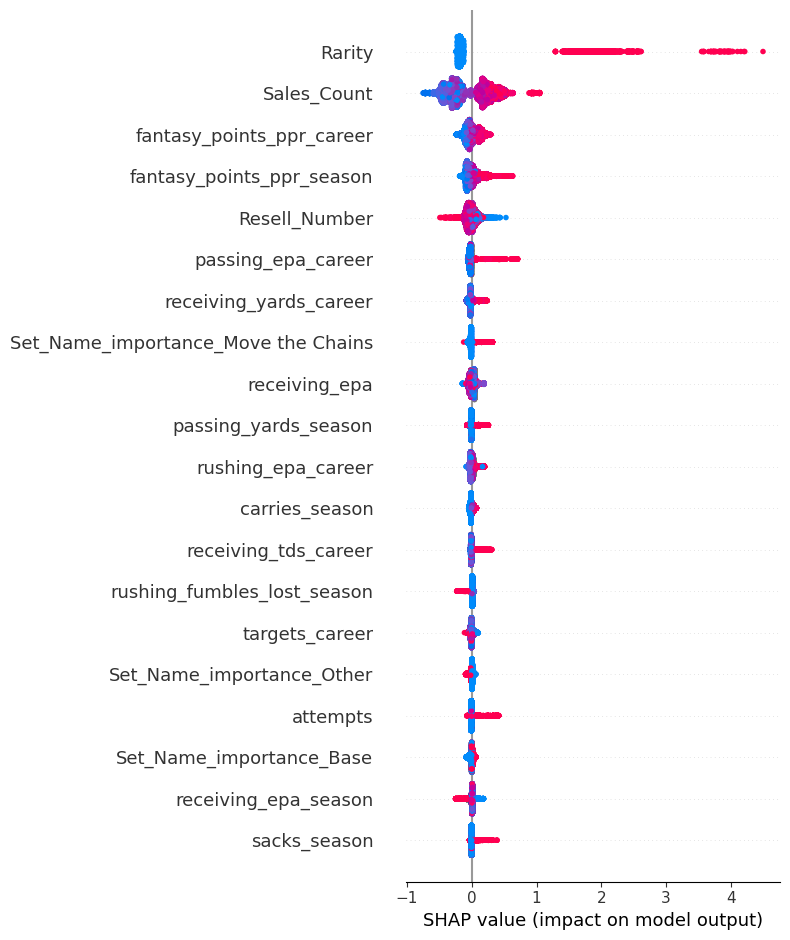

In [128]:
shap.summary_plot(    
    shap_samp, 
    X_samp,
    color_bar=False
)

In [125]:
shap_interaction_values = explainer.shap_interaction_values(X_samp)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


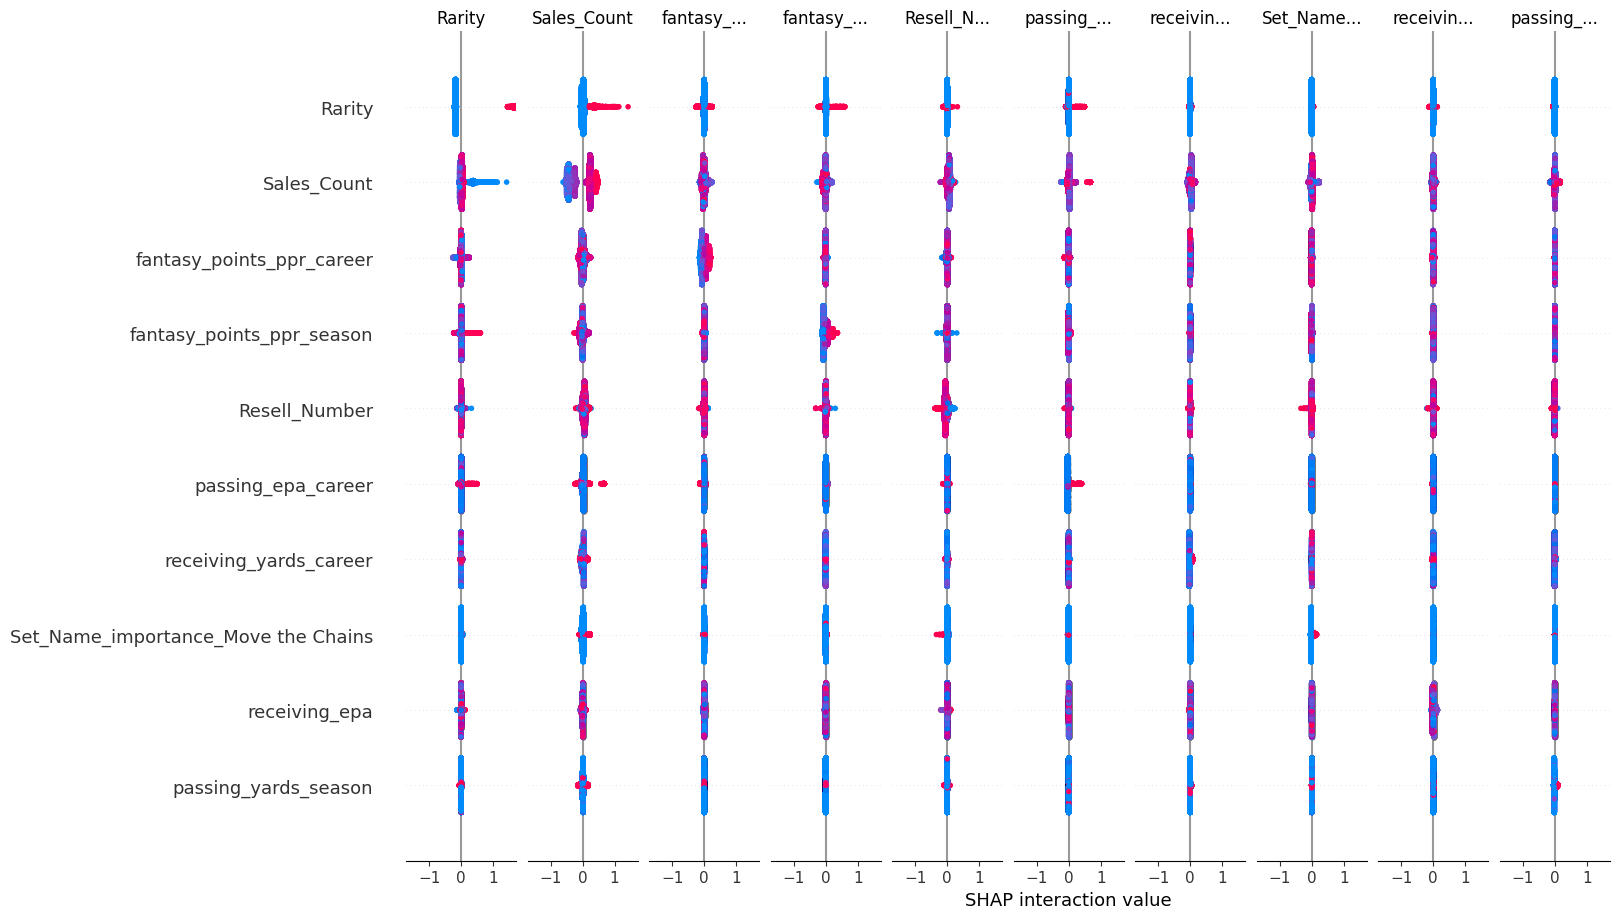

In [126]:
shap.summary_plot(shap_interaction_values, X_samp, max_display=10, color_bar=False)

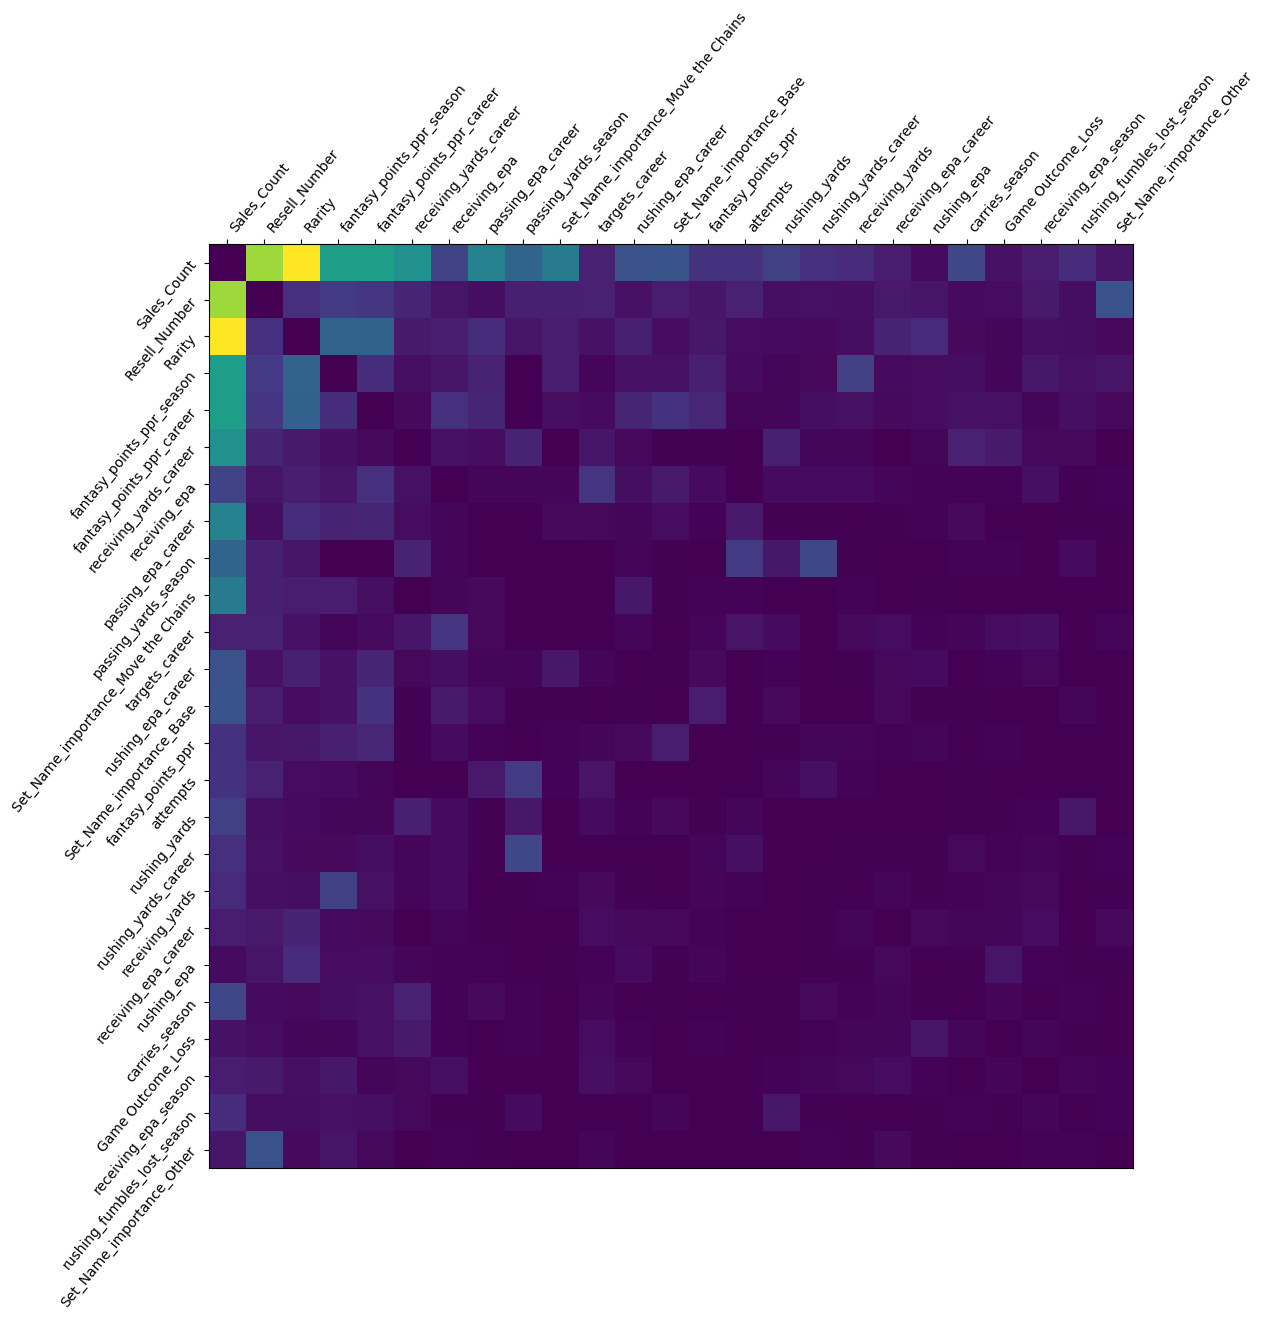

In [127]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:25]
tmp2 = tmp[inds,:][:,inds]
plt.figure(figsize=(12,12))
plt.imshow(tmp2)
plt.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()
plt.show()

In [135]:
for name in  X.columns[:5]:
    shap.dependence_plot(name, shap_samp, X_samp)

TypeError: loop of ufunc does not support argument 0 of type Explanation which has no callable conjugate method

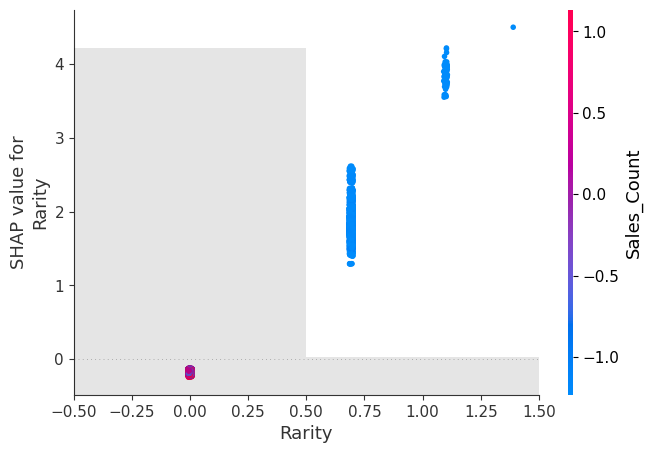

In [136]:
shap.plots.scatter(shap_samp[:,"Rarity"],color=shap_samp)

In [149]:
for x in merged.marketplace_id.unique():
    data = merged[merged.marketplace_id == x]
    player = data.player_display_name.iloc[0].replace(' ', '_')
    print(f"{x}: {len(data)}")
    data.to_csv(f'data/ml/{x}--{player}.csv.gzip', index=False, compression='gzip')


371: 4178
937: 786
394: 5093
893: 898
815: 6521
610: 35
936: 603
1128: 16
798: 6897
429: 5019
762: 878
584: 33
532: 6667
596: 652
377: 1216
1022: 21
1038: 2158
446: 8284
791: 984
992: 10
786: 7057
607: 850
724: 2727
516: 734
622: 5918
778: 6953
654: 3591
587: 30
489: 28
895: 651
1019: 3212
372: 3649
431: 4689
579: 917
686: 4206
440: 6079
642: 836
395: 5007
940: 30
1086: 289
684: 5591
578: 932
675: 35
1060: 465
658: 574
680: 6322
612: 2893
701: 4350
358: 3187
689: 8155
639: 1186
902: 32
619: 4417
1020: 439
756: 5056
645: 41
364: 4308
634: 2951
520: 961
758: 4913
534: 3561
1136: 75
597: 551
570: 3059
403: 509
356: 5797
521: 1293
565: 3450
749: 3898
426: 3642
454: 950
652: 2727
681: 9392
894: 1127
1131: 41
561: 3102
423: 4290
496: 3763
566: 5250
1034: 495
504: 7418
754: 7115
789: 1082
380: 1113
712: 40
829: 32
668: 796
882: 8630
574: 2948
685: 6030
1033: 431
558: 3084
636: 3908
471: 3478
917: 491
727: 4207
417: 783
647: 41
682: 4584
586: 40
547: 1198
458: 52
897: 1442
582: 859
402: 629
10

In [151]:
xgb_model.feature_names_in_

array(['Rarity', 'Sales_Count', 'Resell_Number', 'completions',
       'attempts', 'passing_yards', 'passing_tds', 'interceptions',
       'sacks', 'sack_fumbles_lost', 'passing_epa', 'carries',
       'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
       'rushing_epa', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles_lost', 'receiving_epa',
       'fantasy_points_ppr', 'completions_season', 'attempts_season',
       'passing_yards_season', 'passing_tds_season',
       'interceptions_season', 'sacks_season', 'sack_fumbles_lost_season',
       'passing_epa_season', 'carries_season', 'rushing_yards_season',
       'rushing_tds_season', 'rushing_fumbles_lost_season',
       'rushing_epa_season', 'receptions_season', 'targets_season',
       'receiving_yards_season', 'receiving_tds_season',
       'receiving_fumbles_lost_season', 'receiving_epa_season',
       'fantasy_points_ppr_season', 'completions_career',
       'attempts_career', 'passin

In [145]:
data.player_display_name.iloc[0]

'Chase Claypool'

In [150]:
len(merged.marketplace_id.unique())

474

In [85]:
y_test.sort_values(by="Price",ascending=False)

Price
50946    9.770013
78827    9.711176
78830    9.680406
50944    9.615872
78824    9.524494
...           ...
548676   0.693147
1059838  0.693147
642014   0.693147
629818   0.693147
639616   0.693147

[366255 rows x 1 columns]

In [89]:
np.expm1(y_test.values.ravel()), np.expm1(predictions)

(array([ 9., 74., 65., ..., 10., 35., 89.]),
 array([  7.011372,  63.410675,  20.740816, ...,   9.381419,  30.065647,
        151.98038 ], dtype=float32))